# Notebook para todas as redes usando multclasses

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import cv2
from torch.autograd import Variable
import random
import shutil, sys
import pandas as pd
from PIL import Image
from PIL import ImageFile
#from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from googlenet_pytorch import GoogLeNet 


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jimi/dissertacao/covid19/datasets/2021/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "densenet"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#num_epochs = 500

In [3]:
test = 2

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([             #testar sem fazer transformações aqui
        transforms.Resize((224, 224)), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# trans = ['train','val','test']
# categories = ['train','val','test']

class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device.reset()

Initializing Datasets and Dataloaders...


In [6]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/2021/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneu/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'normal/')]) + len([iq for iq in os.scandir(train_dir+'pneu/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'normal/')]) + len([iq for iq in os.scandir(test_dir+'pneu/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'normal/')]) + len([iq for iq in os.scandir(val_dir+'pneu/')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)

print("pneumonia : ", len_normal)

print("covid : ", len_pneumonia)

print("-"*20)

print('Train, test, validation')

print("-"*20)

print("len_train_dir : ", len_train_dir)

print("len_test_dir : ", len_test_dir)

print("len_val_dir : ", len_val_dir)



Files per classes
----------------------------------------
normal :  1341
pneumonia :  1345
covid :  1170
--------------------
Train, test, validation
--------------------
len_train_dir :  3053
len_test_dir :  39
len_val_dir :  764


In [7]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, 
                model_name, lr, batch_size, opt_name, crt_name):
    since = time.time()
    is_inception = False
    
    #tensorboard
    #writer = SummaryWriter(f'runs/dg_{model_name}_lr={lr}_epoch={num_epochs}_batch_size={batch_size}')
    step = 0

    val_acc_history = []
    val_loss_history = []
    
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            #writer.add_scalar('training loss', loss, global_step=step)
            #writer.add_scalar('training accuracy', epoch_acc, global_step=step)
            step += 1
            
            #only to plot the graph
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        #print()
        
        
    time_elapsed = time.time() - since
    print()
    print('#'*30)
    print('------ Summary ------')
    print(f'model -> {_model}')
    print(f'epochs -> {_epochs}')
    print(f'lr -> {_lrs}')
    print(f'batch size -> {_batch}')
    print(f'optimizer -> {opt_name}'), 
    print(f'criteriun -> {crt_name}')
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('#'*30)
    
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.plot(train_acc_history, label="Validation Loss")
    plt.title('Accuracy in Validation Dataset')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_loss_history, label="val_loss_history")
    plt.plot(train_loss_history, label="train_loss_history")
    plt.title('Loss in Validation Dataset')
    plt.legend()
    plt.tight_layout()
    plt.savefig('img/mult/hist_'+_model+'_opt_'+opt_name+'_crt_'+crt_name+'.png')
    plt.show()

    print()

    print('==== END ====')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [8]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    #
    #googlenet, shufflenet, mobilenet 
    #

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "shufflenet":
        """ shufflenet
        """
        model_ft = models.shufflenet_v2_x1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "mobilenet":
        """ mobilenet
        """
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "googlenet":
        """ googlenet
        """
        model_ft = models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [11]:
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('img/mult/cm_'+title+'.png')


==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5118 Acc: 0.7946
val Loss: 0.3055 Acc: 0.8874
Epoch 1/99
----------
train Loss: 0.2936 Acc: 0.9011
val Loss: 0.2630 Acc: 0.9149
Epoch 2/99
----------
train Loss: 0.2448 Acc: 0.9191
val Loss: 0.2226 Acc: 0.9319
Epoch 3/99
----------
train Loss: 0.2264 Acc: 0.9270
val Loss: 0.2067 Acc: 0.9346
Epoch 4/99
----------
train Loss: 0.2258 Acc: 0.9224
val Loss: 0.2190 Acc: 0.9215
Epoch 5/99
----------
train Loss: 0.2081 Acc: 0.9302
val Loss: 0.2290 Acc: 0.9254
Epoch 6/99
----------
train Loss: 0.1879 Acc: 0.9322
val Loss: 0.2308 Acc: 0.9136
Epoch 7/99
----------
train Loss: 0.2049 Acc: 0.9240
val Loss: 0.1874 Acc: 0.9411
Epoch 8/99
----------
train Loss: 0.1872 Acc: 0.9342
val Loss: 0.1917 Acc: 0.9332
Epoch 9/99
-

train Loss: 0.1190 Acc: 0.9561
val Loss: 0.1730 Acc: 0.9424
Epoch 96/99
----------
train Loss: 0.1183 Acc: 0.9581
val Loss: 0.1476 Acc: 0.9529
Epoch 97/99
----------
train Loss: 0.1223 Acc: 0.9568
val Loss: 0.2117 Acc: 0.9372
Epoch 98/99
----------
train Loss: 0.1300 Acc: 0.9528
val Loss: 0.2385 Acc: 0.9280
Epoch 99/99
----------
train Loss: 0.1516 Acc: 0.9456
val Loss: 0.1949 Acc: 0.9398

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 28m 6s
Best val Acc: 0.959424
##############################


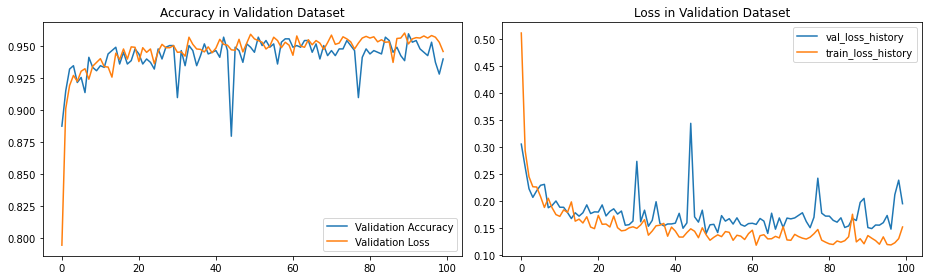


==== END ====
[[233   1   4]
 [  1 251  19]
 [  7   9 239]]

Sensitivity or recall total
0.9463350785340314

Sensitivity or recall per classes
[0.9789916  0.92619926 0.9372549 ]

Precision
[0.96680498 0.96168582 0.91221374]

F1 Score
[0.97286013 0.94360902 0.9245648 ]
Confusion matrix, without normalization

TESTE = 1/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5900 Acc: 0.7802
val Loss: 0.3357 Acc: 0.8783
Epoch 1/99
----------
train Loss: 0.2745 Acc: 0.9161
val Loss: 0.2378 Acc: 0.9175
Epoch 2/99
----------
train Loss: 0.2171 Acc: 0.9348
val Loss: 0.2224 Acc: 0.9241
Epoch 3/99
----------
train Loss: 0.1960 Acc: 0.9394
val Loss: 0.2069 Acc: 0.9385
Epoch 4/99
----------
train Loss: 0.1796 Acc: 0.9420
val Loss: 0.1978 Acc: 0.9332
Epoch 5/99
-----

train Loss: 0.0972 Acc: 0.9650
val Loss: 0.1419 Acc: 0.9594
Epoch 92/99
----------
train Loss: 0.0833 Acc: 0.9728
val Loss: 0.1226 Acc: 0.9620
Epoch 93/99
----------
train Loss: 0.0905 Acc: 0.9663
val Loss: 0.1254 Acc: 0.9581
Epoch 94/99
----------
train Loss: 0.0940 Acc: 0.9679
val Loss: 0.1404 Acc: 0.9620
Epoch 95/99
----------
train Loss: 0.0936 Acc: 0.9663
val Loss: 0.1334 Acc: 0.9555
Epoch 96/99
----------
train Loss: 0.0936 Acc: 0.9633
val Loss: 0.1606 Acc: 0.9529
Epoch 97/99
----------
train Loss: 0.0924 Acc: 0.9705
val Loss: 0.1442 Acc: 0.9529
Epoch 98/99
----------
train Loss: 0.0983 Acc: 0.9646
val Loss: 0.1394 Acc: 0.9607
Epoch 99/99
----------
train Loss: 0.0983 Acc: 0.9653
val Loss: 0.1348 Acc: 0.9607

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 27m 39s
Best val Acc: 0.964660
##############################


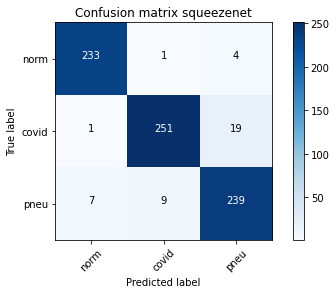

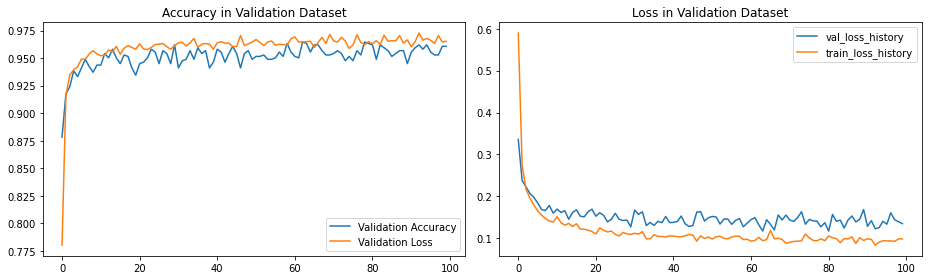


==== END ====
[[233   1   4]
 [  0 263   8]
 [  6  12 237]]

Sensitivity or recall total
0.9594240837696335

Sensitivity or recall per classes
[0.98 0.97 0.93]

Precision
[0.97 0.95 0.95]

F1 Score
[0.98 0.96 0.94]
Confusion matrix, without normalization

TESTE = 2/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4928 Acc: 0.8120
val Loss: 0.3103 Acc: 0.8901
Epoch 1/99
----------
train Loss: 0.2613 Acc: 0.9184
val Loss: 0.3249 Acc: 0.8770
Epoch 2/99
----------
train Loss: 0.2277 Acc: 0.9250
val Loss: 0.2206 Acc: 0.9202
Epoch 3/99
----------
train Loss: 0.1908 Acc: 0.9420
val Loss: 0.2025 Acc: 0.9437
Epoch 4/99
----------
train Loss: 0.1853 Acc: 0.9394
val Loss: 0.2052 Acc: 0.9332
Epoch 5/99
----------
train Loss: 0.1699 Acc: 0.9427
val Loss: 0.1768 

train Loss: 0.0905 Acc: 0.9669
val Loss: 0.1991 Acc: 0.9385
Epoch 93/99
----------
train Loss: 0.0986 Acc: 0.9650
val Loss: 0.1337 Acc: 0.9529
Epoch 94/99
----------
train Loss: 0.0969 Acc: 0.9646
val Loss: 0.1383 Acc: 0.9555
Epoch 95/99
----------
train Loss: 0.1011 Acc: 0.9623
val Loss: 0.1852 Acc: 0.9476
Epoch 96/99
----------
train Loss: 0.1017 Acc: 0.9650
val Loss: 0.1530 Acc: 0.9490
Epoch 97/99
----------
train Loss: 0.0970 Acc: 0.9656
val Loss: 0.2524 Acc: 0.9267
Epoch 98/99
----------
train Loss: 0.0927 Acc: 0.9656
val Loss: 0.1337 Acc: 0.9620
Epoch 99/99
----------
train Loss: 0.1109 Acc: 0.9607
val Loss: 0.1924 Acc: 0.9359

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 27m 32s
Best val Acc: 0.963351
##############################


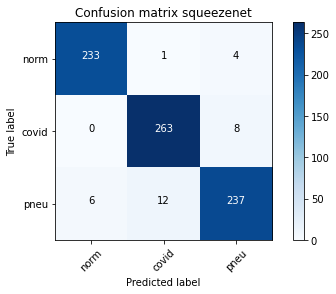

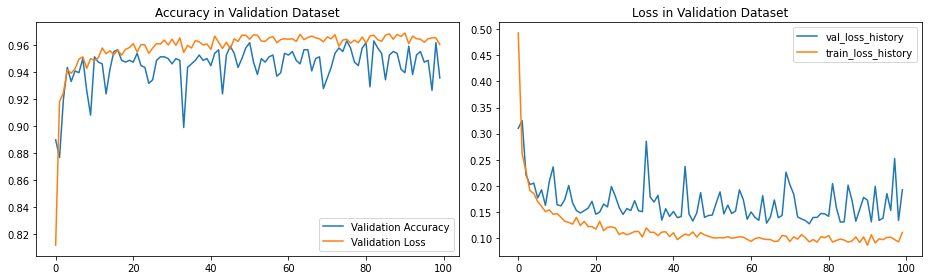


==== END ====
[[231   1   6]
 [  0 261  10]
 [  4   8 243]]

Sensitivity or recall total
0.9620418848167539

Sensitivity or recall per classes
[0.97 0.96 0.95]

Precision
[0.98 0.97 0.94]

F1 Score
[0.98 0.96 0.95]
Confusion matrix, without normalization

TESTE = 3/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5931 Acc: 0.7511
val Loss: 0.4839 Acc: 0.7945
Epoch 1/99
----------
train Loss: 0.3017 Acc: 0.8968
val Loss: 0.2507 Acc: 0.9215
Epoch 2/99
----------
train Loss: 0.2725 Acc: 0.9040
val Loss: 0.2813 Acc: 0.9031
Epoch 3/99
----------
train Loss: 0.2398 Acc: 0.9214
val Loss: 0.2410 Acc: 0.9123
Epoch 4/99
----------
train Loss: 0.2150 Acc: 0.9309
val Loss: 0.2067 Acc: 0.9359
Epoch 5/99
----------
train Loss: 0.2117 Acc: 0.9273
val Loss: 0.2005

train Loss: 0.1295 Acc: 0.9568
val Loss: 0.1656 Acc: 0.9437
Epoch 93/99
----------
train Loss: 0.1296 Acc: 0.9528
val Loss: 0.1534 Acc: 0.9529
Epoch 94/99
----------
train Loss: 0.1340 Acc: 0.9571
val Loss: 0.1477 Acc: 0.9529
Epoch 95/99
----------
train Loss: 0.1348 Acc: 0.9525
val Loss: 0.1632 Acc: 0.9463
Epoch 96/99
----------
train Loss: 0.1260 Acc: 0.9528
val Loss: 0.1605 Acc: 0.9490
Epoch 97/99
----------
train Loss: 0.1288 Acc: 0.9538
val Loss: 0.1817 Acc: 0.9424
Epoch 98/99
----------
train Loss: 0.1385 Acc: 0.9522
val Loss: 0.1697 Acc: 0.9476
Epoch 99/99
----------
train Loss: 0.1222 Acc: 0.9587
val Loss: 0.1636 Acc: 0.9503

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 27m 38s
Best val Acc: 0.956806
##############################


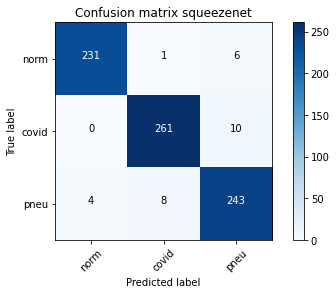

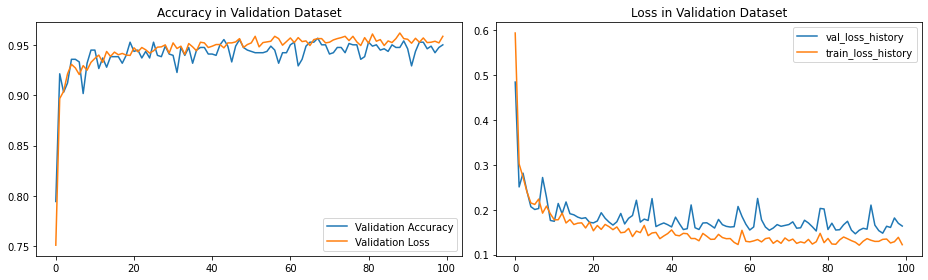


==== END ====
[[232   2   4]
 [  0 254  17]
 [  5   7 243]]

Sensitivity or recall total
0.9541884816753927

Sensitivity or recall per classes
[0.97 0.94 0.95]

Precision
[0.98 0.97 0.92]

F1 Score
[0.98 0.95 0.94]
Confusion matrix, without normalization

TESTE = 4/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.6050 Acc: 0.7727
val Loss: 0.3335 Acc: 0.8743
Epoch 1/99
----------
train Loss: 0.2726 Acc: 0.9207
val Loss: 0.2496 Acc: 0.9149
Epoch 2/99
----------
train Loss: 0.2236 Acc: 0.9286
val Loss: 0.2344 Acc: 0.9202
Epoch 3/99
----------
train Loss: 0.2089 Acc: 0.9332
val Loss: 0.2115 Acc: 0.9280
Epoch 4/99
----------
train Loss: 0.1827 Acc: 0.9430
val Loss: 0.1907 Acc: 0.9411
Epoch 5/99
----------
train Loss: 0.1714 Acc: 0.9456
val Loss: 0.1957

train Loss: 0.0997 Acc: 0.9610
val Loss: 0.1252 Acc: 0.9647
Epoch 93/99
----------
train Loss: 0.1095 Acc: 0.9594
val Loss: 0.1502 Acc: 0.9555
Epoch 94/99
----------
train Loss: 0.0843 Acc: 0.9722
val Loss: 0.1509 Acc: 0.9516
Epoch 95/99
----------
train Loss: 0.0943 Acc: 0.9682
val Loss: 0.1421 Acc: 0.9607
Epoch 96/99
----------
train Loss: 0.0896 Acc: 0.9689
val Loss: 0.1598 Acc: 0.9516
Epoch 97/99
----------
train Loss: 0.0896 Acc: 0.9672
val Loss: 0.1338 Acc: 0.9607
Epoch 98/99
----------
train Loss: 0.0991 Acc: 0.9646
val Loss: 0.1532 Acc: 0.9503
Epoch 99/99
----------
train Loss: 0.0888 Acc: 0.9695
val Loss: 0.1516 Acc: 0.9620

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 27m 39s
Best val Acc: 0.965969
##############################


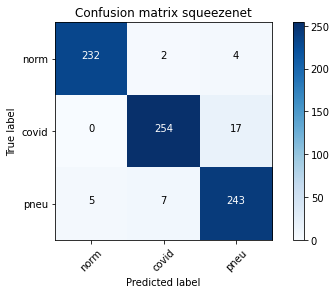

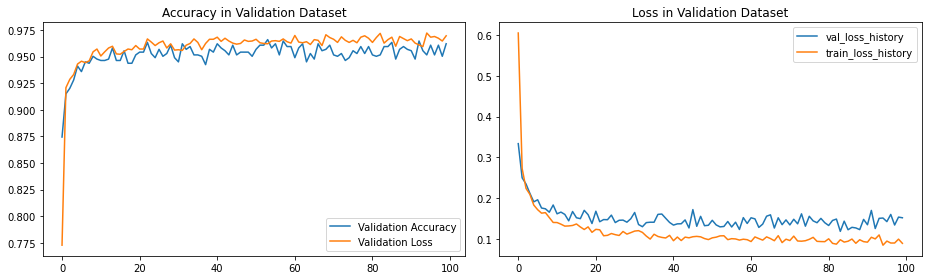


==== END ====
[[232   2   4]
 [  0 264   7]
 [  3  11 241]]

Sensitivity or recall total
0.9646596858638743

Sensitivity or recall per classes
[0.97 0.97 0.95]

Precision
[0.99 0.95 0.96]

F1 Score
[0.98 0.96 0.95]
Confusion matrix, without normalization

TESTE = 5/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4974 Acc: 0.8205
val Loss: 0.2999 Acc: 0.9058
Epoch 1/99
----------
train Loss: 0.2639 Acc: 0.9194
val Loss: 0.2443 Acc: 0.9306
Epoch 2/99
----------
train Loss: 0.2254 Acc: 0.9273
val Loss: 0.3613 Acc: 0.8599
Epoch 3/99
----------
train Loss: 0.2078 Acc: 0.9312
val Loss: 0.2744 Acc: 0.9071
Epoch 4/99
----------
train Loss: 0.1892 Acc: 0.9387
val Loss: 0.1926 Acc: 0.9424
Epoch 5/99
----------
train Loss: 0.1693 Acc: 0.9446
val Loss: 0.3444

train Loss: 0.1010 Acc: 0.9623
val Loss: 0.1330 Acc: 0.9594
Epoch 93/99
----------
train Loss: 0.0861 Acc: 0.9663
val Loss: 0.1215 Acc: 0.9634
Epoch 94/99
----------
train Loss: 0.0978 Acc: 0.9623
val Loss: 0.1698 Acc: 0.9463
Epoch 95/99
----------
train Loss: 0.0972 Acc: 0.9650
val Loss: 0.1446 Acc: 0.9568
Epoch 96/99
----------
train Loss: 0.1031 Acc: 0.9627
val Loss: 0.1447 Acc: 0.9594
Epoch 97/99
----------
train Loss: 0.1048 Acc: 0.9584
val Loss: 0.1494 Acc: 0.9529
Epoch 98/99
----------
train Loss: 0.0948 Acc: 0.9643
val Loss: 0.1877 Acc: 0.9372
Epoch 99/99
----------
train Loss: 0.0987 Acc: 0.9646
val Loss: 0.1330 Acc: 0.9620

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 27m 35s
Best val Acc: 0.963351
##############################


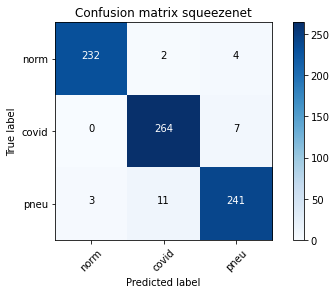

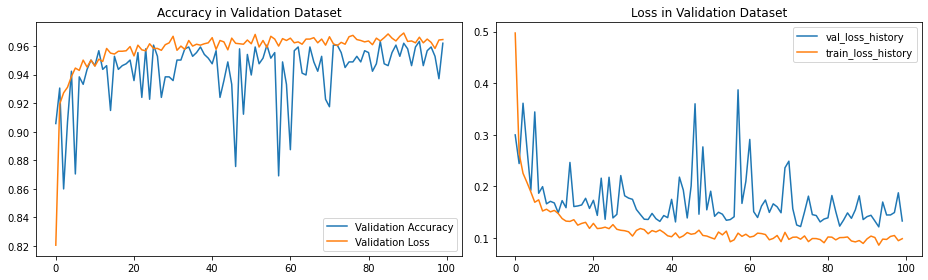


==== END ====
[[233   1   4]
 [  0 258  13]
 [  6   7 242]]

Sensitivity or recall total
0.9594240837696335

Sensitivity or recall per classes
[0.98 0.95 0.95]

Precision
[0.97 0.97 0.93]

F1 Score
[0.98 0.96 0.94]
Confusion matrix, without normalization

TESTE = 6/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5974 Acc: 0.7422
val Loss: 0.3485 Acc: 0.8691
Epoch 1/99
----------
train Loss: 0.3331 Acc: 0.8765
val Loss: 0.2637 Acc: 0.9215
Epoch 2/99
----------
train Loss: 0.2645 Acc: 0.9096
val Loss: 0.2430 Acc: 0.9254
Epoch 3/99
----------
train Loss: 0.2340 Acc: 0.9240
val Loss: 0.2398 Acc: 0.9228
Epoch 4/99
----------
train Loss: 0.2373 Acc: 0.9230
val Loss: 0.3134 Acc: 0.8783
Epoch 5/99
----------
train Loss: 0.2038 Acc: 0.9299
val Loss: 0.2140

train Loss: 0.1136 Acc: 0.9640
val Loss: 0.1701 Acc: 0.9437
Epoch 93/99
----------
train Loss: 0.1164 Acc: 0.9597
val Loss: 0.1805 Acc: 0.9490
Epoch 94/99
----------
train Loss: 0.1236 Acc: 0.9564
val Loss: 0.1618 Acc: 0.9490
Epoch 95/99
----------
train Loss: 0.1240 Acc: 0.9591
val Loss: 0.1456 Acc: 0.9555
Epoch 96/99
----------
train Loss: 0.1290 Acc: 0.9545
val Loss: 0.1688 Acc: 0.9476
Epoch 97/99
----------
train Loss: 0.1184 Acc: 0.9587
val Loss: 0.1586 Acc: 0.9476
Epoch 98/99
----------
train Loss: 0.1173 Acc: 0.9633
val Loss: 0.1609 Acc: 0.9516
Epoch 99/99
----------
train Loss: 0.1301 Acc: 0.9571
val Loss: 0.1522 Acc: 0.9516

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 27m 36s
Best val Acc: 0.958115
##############################


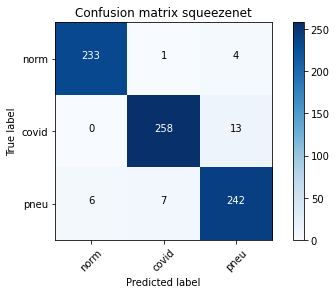

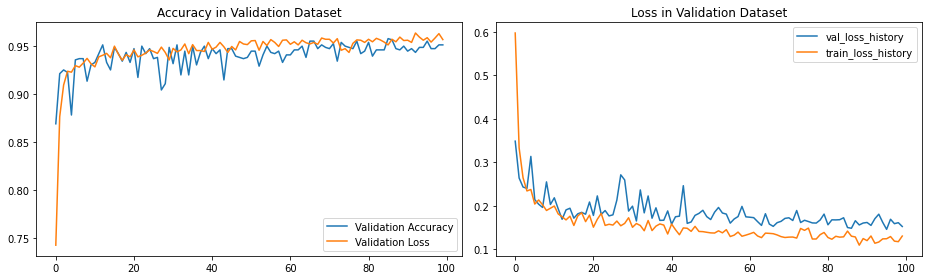


==== END ====
[[233   1   4]
 [  1 255  15]
 [  6  12 237]]

Sensitivity or recall total
0.9489528795811518

Sensitivity or recall per classes
[0.98 0.94 0.93]

Precision
[0.97 0.95 0.93]

F1 Score
[0.97 0.95 0.93]
Confusion matrix, without normalization

TESTE = 7/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.6318 Acc: 0.7481
val Loss: 0.3400 Acc: 0.8979
Epoch 1/99
----------
train Loss: 0.2944 Acc: 0.9155
val Loss: 0.2670 Acc: 0.9188
Epoch 2/99
----------
train Loss: 0.2298 Acc: 0.9325
val Loss: 0.2334 Acc: 0.9202
Epoch 3/99
----------
train Loss: 0.1984 Acc: 0.9404
val Loss: 0.1996 Acc: 0.9319
Epoch 4/99
----------
train Loss: 0.1875 Acc: 0.9404
val Loss: 0.2110 Acc: 0.9241
Epoch 5/99
----------
train Loss: 0.1744 Acc: 0.9430
val Loss: 0.1851

train Loss: 0.0900 Acc: 0.9666
val Loss: 0.1369 Acc: 0.9594
Epoch 93/99
----------
train Loss: 0.1009 Acc: 0.9636
val Loss: 0.1367 Acc: 0.9555
Epoch 94/99
----------
train Loss: 0.0895 Acc: 0.9686
val Loss: 0.1476 Acc: 0.9529
Epoch 95/99
----------
train Loss: 0.1008 Acc: 0.9633
val Loss: 0.1737 Acc: 0.9490
Epoch 96/99
----------
train Loss: 0.0894 Acc: 0.9699
val Loss: 0.1408 Acc: 0.9542
Epoch 97/99
----------
train Loss: 0.0992 Acc: 0.9643
val Loss: 0.1370 Acc: 0.9555
Epoch 98/99
----------
train Loss: 0.0922 Acc: 0.9676
val Loss: 0.1402 Acc: 0.9476
Epoch 99/99
----------
train Loss: 0.0936 Acc: 0.9636
val Loss: 0.1221 Acc: 0.9607

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 27m 37s
Best val Acc: 0.963351
##############################


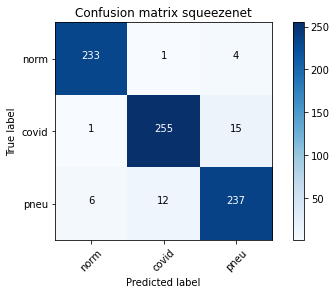

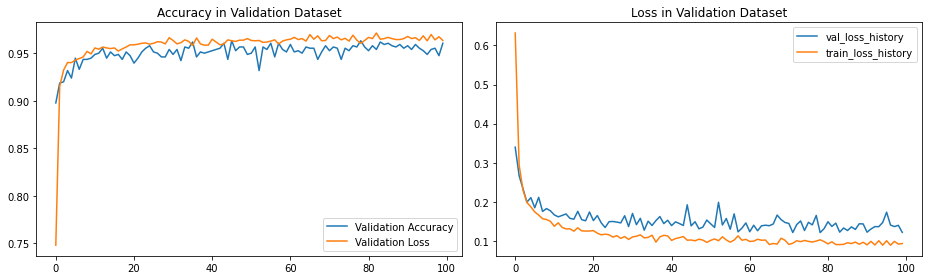


==== END ====
[[231   1   6]
 [  0 262   9]
 [  5  12 238]]

Sensitivity or recall total
0.9568062827225131

Sensitivity or recall per classes
[0.97 0.97 0.93]

Precision
[0.98 0.95 0.94]

F1 Score
[0.97 0.96 0.94]
Confusion matrix, without normalization

TESTE = 8/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4907 Acc: 0.8388
val Loss: 0.3905 Acc: 0.8442
Epoch 1/99
----------
train Loss: 0.2733 Acc: 0.9119
val Loss: 0.2478 Acc: 0.9149
Epoch 2/99
----------
train Loss: 0.2302 Acc: 0.9234
val Loss: 0.2702 Acc: 0.9031
Epoch 3/99
----------
train Loss: 0.2066 Acc: 0.9371
val Loss: 0.2722 Acc: 0.9097
Epoch 4/99
----------
train Loss: 0.1854 Acc: 0.9391
val Loss: 0.2254 Acc: 0.9241
Epoch 5/99
----------
train Loss: 0.1842 Acc: 0.9397
val Loss: 0.2218

train Loss: 0.0970 Acc: 0.9627
val Loss: 0.1897 Acc: 0.9346
Epoch 93/99
----------
train Loss: 0.1025 Acc: 0.9650
val Loss: 0.1530 Acc: 0.9503
Epoch 94/99
----------
train Loss: 0.1033 Acc: 0.9623
val Loss: 0.1511 Acc: 0.9594
Epoch 95/99
----------
train Loss: 0.0897 Acc: 0.9672
val Loss: 0.1404 Acc: 0.9555
Epoch 96/99
----------
train Loss: 0.0924 Acc: 0.9659
val Loss: 0.1333 Acc: 0.9581
Epoch 97/99
----------
train Loss: 0.0936 Acc: 0.9656
val Loss: 0.1416 Acc: 0.9594
Epoch 98/99
----------
train Loss: 0.0938 Acc: 0.9663
val Loss: 0.1748 Acc: 0.9476
Epoch 99/99
----------
train Loss: 0.0875 Acc: 0.9702
val Loss: 0.1355 Acc: 0.9607

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 27m 36s
Best val Acc: 0.965969
##############################


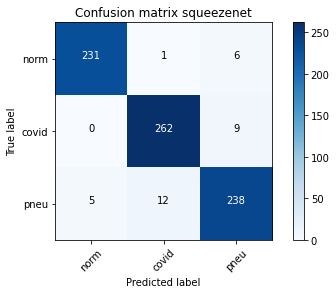

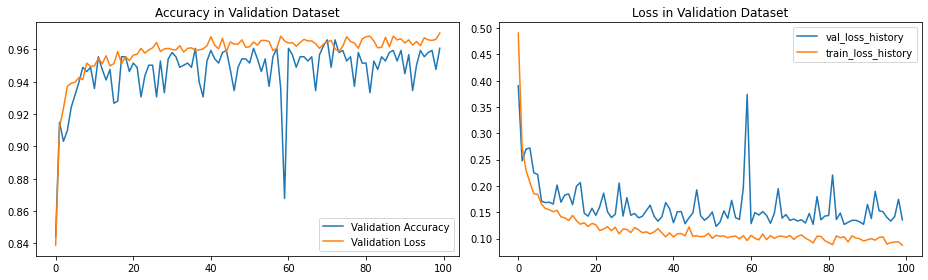


==== END ====
[[232   1   5]
 [  0 259  12]
 [  7   8 240]]

Sensitivity or recall total
0.9568062827225131

Sensitivity or recall per classes
[0.97 0.96 0.94]

Precision
[0.97 0.97 0.93]

F1 Score
[0.97 0.96 0.94]
Confusion matrix, without normalization

TESTE = 9/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0200 Acc: 0.5116
val Loss: 0.8081 Acc: 0.7251
Epoch 1/99
----------
train Loss: 0.6959 Acc: 0.7638
val Loss: 0.5601 Acc: 0.8050
Epoch 2/99
----------
train Loss: 0.5121 Acc: 0.8503
val Loss: 0.4590 Acc: 0.8508
Epoch 3/99
----------
train Loss: 0.4361 Acc: 0.8673
val Loss: 0.3955 Acc: 0.8730
Epoch 4/99
----------
train Loss: 0.3823 Acc: 0.8867
val Loss: 0.3670 Acc: 0.8757
Epoch 5/99
----------
train Loss: 0.3581 Acc: 0.8916
val Loss: 0.3491

train Loss: 0.1679 Acc: 0.9486
val Loss: 0.1917 Acc: 0.9437
Epoch 93/99
----------
train Loss: 0.1658 Acc: 0.9492
val Loss: 0.1944 Acc: 0.9385
Epoch 94/99
----------
train Loss: 0.1595 Acc: 0.9492
val Loss: 0.1929 Acc: 0.9411
Epoch 95/99
----------
train Loss: 0.1674 Acc: 0.9482
val Loss: 0.1812 Acc: 0.9463
Epoch 96/99
----------
train Loss: 0.1639 Acc: 0.9515
val Loss: 0.1978 Acc: 0.9490
Epoch 97/99
----------
train Loss: 0.1650 Acc: 0.9479
val Loss: 0.1822 Acc: 0.9437
Epoch 98/99
----------
train Loss: 0.1679 Acc: 0.9453
val Loss: 0.1801 Acc: 0.9463
Epoch 99/99
----------
train Loss: 0.1732 Acc: 0.9440
val Loss: 0.1823 Acc: 0.9437

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 27m 40s
Best val Acc: 0.950262
##############################


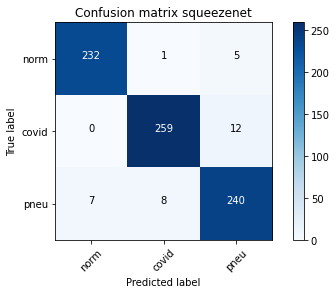

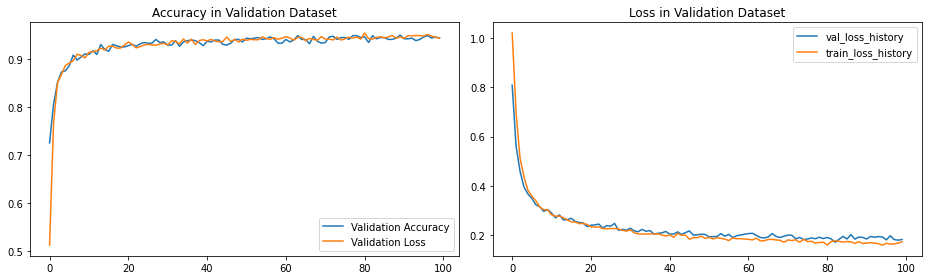


==== END ====
[[233   1   4]
 [  1 248  22]
 [  6  12 237]]

Sensitivity or recall total
0.9397905759162304

Sensitivity or recall per classes
[0.98 0.92 0.93]

Precision
[0.97 0.95 0.9 ]

F1 Score
[0.97 0.93 0.92]
Confusion matrix, without normalization

TESTE = 10/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.1512 Acc: 0.3505
val Loss: 0.9563 Acc: 0.5510
Epoch 1/99
----------
train Loss: 0.8927 Acc: 0.6151
val Loss: 0.7757 Acc: 0.7003
Epoch 2/99
----------
train Loss: 0.7344 Acc: 0.7481
val Loss: 0.6440 Acc: 0.7958
Epoch 3/99
----------
train Loss: 0.6170 Acc: 0.8198
val Loss: 0.5247 Acc: 0.8455
Epoch 4/99
----------
train Loss: 0.5250 Acc: 0.8565
val Loss: 0.4589 Acc: 0.8691
Epoch 5/99
----------
train Loss: 0.4613 Acc: 0.8683
val Loss: 0.438

train Loss: 0.1293 Acc: 0.9574
val Loss: 0.1558 Acc: 0.9516
Epoch 93/99
----------
train Loss: 0.1263 Acc: 0.9587
val Loss: 0.1578 Acc: 0.9450
Epoch 94/99
----------
train Loss: 0.1256 Acc: 0.9594
val Loss: 0.1631 Acc: 0.9476
Epoch 95/99
----------
train Loss: 0.1246 Acc: 0.9630
val Loss: 0.1626 Acc: 0.9490
Epoch 96/99
----------
train Loss: 0.1274 Acc: 0.9604
val Loss: 0.1614 Acc: 0.9542
Epoch 97/99
----------
train Loss: 0.1203 Acc: 0.9623
val Loss: 0.1617 Acc: 0.9450
Epoch 98/99
----------
train Loss: 0.1305 Acc: 0.9564
val Loss: 0.1544 Acc: 0.9503
Epoch 99/99
----------
train Loss: 0.1238 Acc: 0.9594
val Loss: 0.1625 Acc: 0.9542

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 27m 43s
Best val Acc: 0.955497
##############################


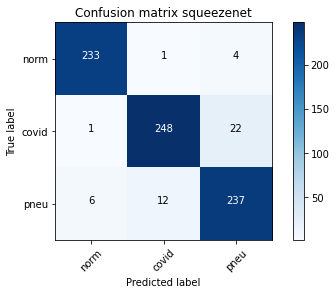

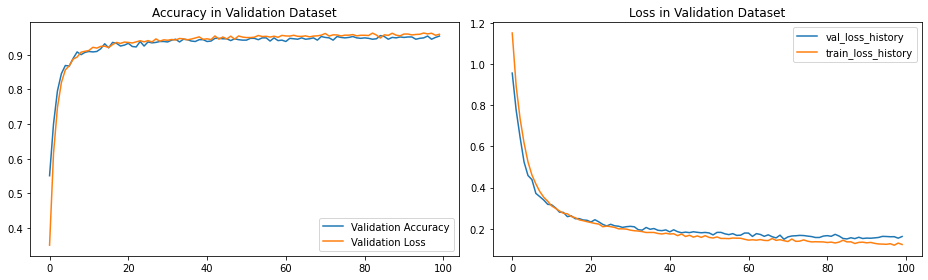


==== END ====
[[231   1   6]
 [  0 257  14]
 [  4  13 238]]

Sensitivity or recall total
0.9502617801047121

Sensitivity or recall per classes
[0.97 0.95 0.93]

Precision
[0.98 0.95 0.92]

F1 Score
[0.98 0.95 0.93]
Confusion matrix, without normalization

TESTE = 11/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.7949 Acc: 0.6895
val Loss: 0.6463 Acc: 0.7893
Epoch 1/99
----------
train Loss: 0.6066 Acc: 0.8225
val Loss: 0.5282 Acc: 0.8416
Epoch 2/99
----------
train Loss: 0.5078 Acc: 0.8598
val Loss: 0.4539 Acc: 0.8665
Epoch 3/99
----------
train Loss: 0.4399 Acc: 0.8795
val Loss: 0.4042 Acc: 0.8861
Epoch 4/99
----------
train Loss: 0.4016 Acc: 0.8929
val Loss: 0.3636 Acc: 0.9005
Epoch 5/99
----------
train Loss: 0.3623 Acc: 0.9021
val Loss: 0.345

train Loss: 0.1262 Acc: 0.9604
val Loss: 0.1489 Acc: 0.9503
Epoch 93/99
----------
train Loss: 0.1272 Acc: 0.9591
val Loss: 0.1505 Acc: 0.9568
Epoch 94/99
----------
train Loss: 0.1291 Acc: 0.9584
val Loss: 0.1639 Acc: 0.9424
Epoch 95/99
----------
train Loss: 0.1224 Acc: 0.9604
val Loss: 0.1536 Acc: 0.9476
Epoch 96/99
----------
train Loss: 0.1296 Acc: 0.9564
val Loss: 0.1477 Acc: 0.9516
Epoch 97/99
----------
train Loss: 0.1190 Acc: 0.9627
val Loss: 0.1461 Acc: 0.9594
Epoch 98/99
----------
train Loss: 0.1247 Acc: 0.9610
val Loss: 0.1579 Acc: 0.9463
Epoch 99/99
----------
train Loss: 0.1251 Acc: 0.9643
val Loss: 0.1515 Acc: 0.9529

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 27m 39s
Best val Acc: 0.959424
##############################


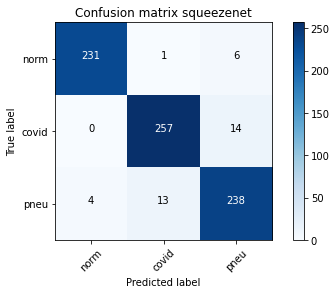

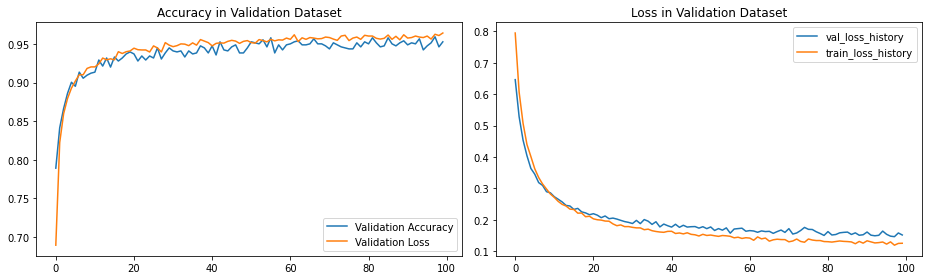


==== END ====
[[233   1   4]
 [  2 257  12]
 [  5  11 239]]

Sensitivity or recall total
0.9541884816753927

Sensitivity or recall per classes
[0.98 0.95 0.94]

Precision
[0.97 0.96 0.94]

F1 Score
[0.97 0.95 0.94]
Confusion matrix, without normalization

TESTE = 12/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0178 Acc: 0.5251
val Loss: 0.7984 Acc: 0.6898
Epoch 1/99
----------
train Loss: 0.7142 Acc: 0.7445
val Loss: 0.6103 Acc: 0.7814
Epoch 2/99
----------
train Loss: 0.5638 Acc: 0.8051
val Loss: 0.4907 Acc: 0.8128
Epoch 3/99
----------
train Loss: 0.4873 Acc: 0.8382
val Loss: 0.4299 Acc: 0.8442
Epoch 4/99
----------
train Loss: 0.4347 Acc: 0.8628
val Loss: 0.3861 Acc: 0.8757
Epoch 5/99
----------
train Loss: 0.3965 Acc: 0.8785
val Loss: 0.38

train Loss: 0.1593 Acc: 0.9450
val Loss: 0.1844 Acc: 0.9398
Epoch 93/99
----------
train Loss: 0.1623 Acc: 0.9512
val Loss: 0.1781 Acc: 0.9490
Epoch 94/99
----------
train Loss: 0.1631 Acc: 0.9505
val Loss: 0.1819 Acc: 0.9490
Epoch 95/99
----------
train Loss: 0.1653 Acc: 0.9450
val Loss: 0.1673 Acc: 0.9503
Epoch 96/99
----------
train Loss: 0.1722 Acc: 0.9414
val Loss: 0.1896 Acc: 0.9463
Epoch 97/99
----------
train Loss: 0.1665 Acc: 0.9489
val Loss: 0.1777 Acc: 0.9450
Epoch 98/99
----------
train Loss: 0.1600 Acc: 0.9505
val Loss: 0.1871 Acc: 0.9385
Epoch 99/99
----------
train Loss: 0.1643 Acc: 0.9482
val Loss: 0.1664 Acc: 0.9503

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 27m 43s
Best val Acc: 0.950262
##############################


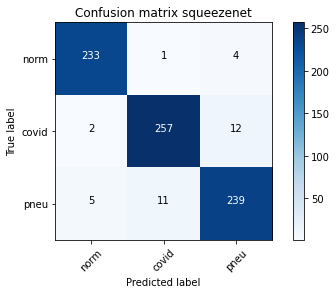

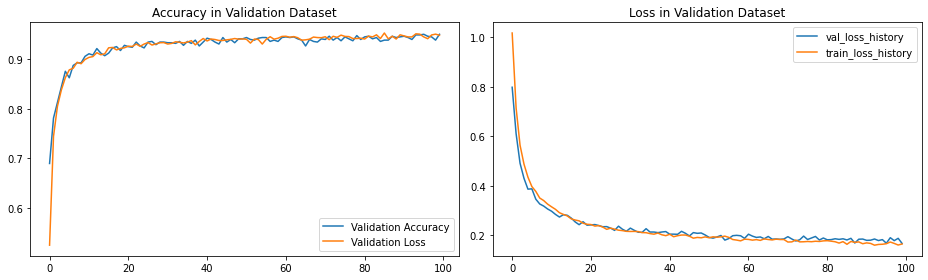


==== END ====
[[233   1   4]
 [  1 254  16]
 [ 10  13 232]]

Sensitivity or recall total
0.9410994764397905

Sensitivity or recall per classes
[0.98 0.94 0.91]

Precision
[0.95 0.95 0.92]

F1 Score
[0.97 0.94 0.92]
Confusion matrix, without normalization

TESTE = 13/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0338 Acc: 0.4690
val Loss: 0.8854 Acc: 0.5942
Epoch 1/99
----------
train Loss: 0.8247 Acc: 0.6708
val Loss: 0.7099 Acc: 0.7565
Epoch 2/99
----------
train Loss: 0.6820 Acc: 0.7766
val Loss: 0.5808 Acc: 0.8181
Epoch 3/99
----------
train Loss: 0.5785 Acc: 0.8271
val Loss: 0.4917 Acc: 0.8678
Epoch 4/99
----------
train Loss: 0.4923 Acc: 0.8726
val Loss: 0.4356 Acc: 0.8822
Epoch 5/99
----------
train Loss: 0.4333 Acc: 0.8899
val Loss: 0.39

train Loss: 0.1305 Acc: 0.9600
val Loss: 0.1505 Acc: 0.9542
Epoch 93/99
----------
train Loss: 0.1311 Acc: 0.9584
val Loss: 0.1621 Acc: 0.9529
Epoch 94/99
----------
train Loss: 0.1279 Acc: 0.9581
val Loss: 0.1618 Acc: 0.9503
Epoch 95/99
----------
train Loss: 0.1277 Acc: 0.9613
val Loss: 0.1493 Acc: 0.9620
Epoch 96/99
----------
train Loss: 0.1335 Acc: 0.9561
val Loss: 0.1518 Acc: 0.9516
Epoch 97/99
----------
train Loss: 0.1246 Acc: 0.9600
val Loss: 0.1495 Acc: 0.9568
Epoch 98/99
----------
train Loss: 0.1285 Acc: 0.9604
val Loss: 0.1633 Acc: 0.9516
Epoch 99/99
----------
train Loss: 0.1245 Acc: 0.9627
val Loss: 0.1626 Acc: 0.9542

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 27m 39s
Best val Acc: 0.962042
##############################


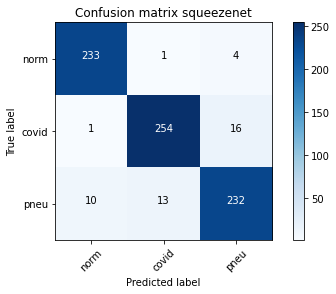

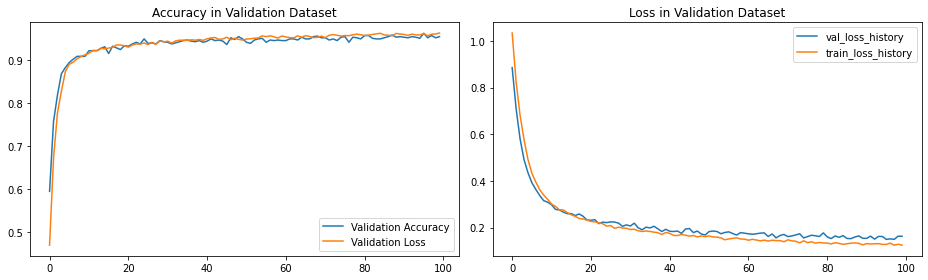


==== END ====
[[233   1   4]
 [  0 258  13]
 [  6   9 240]]

Sensitivity or recall total
0.9568062827225131

Sensitivity or recall per classes
[0.98 0.95 0.94]

Precision
[0.97 0.96 0.93]

F1 Score
[0.98 0.96 0.94]
Confusion matrix, without normalization

TESTE = 14/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.8721 Acc: 0.6263
val Loss: 0.7122 Acc: 0.7448
Epoch 1/99
----------
train Loss: 0.6599 Acc: 0.7966
val Loss: 0.5638 Acc: 0.8141
Epoch 2/99
----------
train Loss: 0.5406 Acc: 0.8457
val Loss: 0.4782 Acc: 0.8586
Epoch 3/99
----------
train Loss: 0.4629 Acc: 0.8752
val Loss: 0.4276 Acc: 0.8665
Epoch 4/99
----------
train Loss: 0.4156 Acc: 0.8808
val Loss: 0.3906 Acc: 0.8691
Epoch 5/99
----------
train Loss: 0.3764 Acc: 0.8985
val Loss: 0.36

train Loss: 0.1251 Acc: 0.9607
val Loss: 0.1544 Acc: 0.9516
Epoch 93/99
----------
train Loss: 0.1249 Acc: 0.9610
val Loss: 0.1515 Acc: 0.9490
Epoch 94/99
----------
train Loss: 0.1281 Acc: 0.9630
val Loss: 0.1564 Acc: 0.9529
Epoch 95/99
----------
train Loss: 0.1244 Acc: 0.9613
val Loss: 0.1601 Acc: 0.9463
Epoch 96/99
----------
train Loss: 0.1229 Acc: 0.9587
val Loss: 0.1548 Acc: 0.9490
Epoch 97/99
----------
train Loss: 0.1258 Acc: 0.9620
val Loss: 0.1499 Acc: 0.9516
Epoch 98/99
----------
train Loss: 0.1252 Acc: 0.9627
val Loss: 0.1493 Acc: 0.9568
Epoch 99/99
----------
train Loss: 0.1317 Acc: 0.9587
val Loss: 0.1506 Acc: 0.9516

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 27m 40s
Best val Acc: 0.956806
##############################


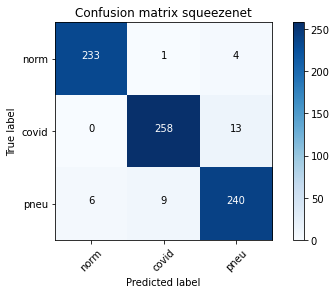

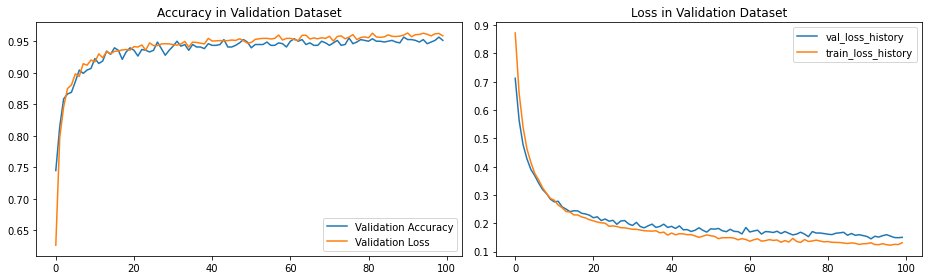


==== END ====
[[233   1   4]
 [  0 260  11]
 [  4  12 239]]

Sensitivity or recall total
0.9581151832460733

Sensitivity or recall per classes
[0.98 0.96 0.94]

Precision
[0.98 0.95 0.94]

F1 Score
[0.98 0.96 0.94]
Confusion matrix, without normalization

TESTE = 15/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.9737 Acc: 0.5477
val Loss: 0.8035 Acc: 0.7055
Epoch 1/99
----------
train Loss: 0.6834 Acc: 0.7697
val Loss: 0.5377 Acc: 0.8298
Epoch 2/99
----------
train Loss: 0.5146 Acc: 0.8402
val Loss: 0.4439 Acc: 0.8586
Epoch 3/99
----------
train Loss: 0.4403 Acc: 0.8660
val Loss: 0.3960 Acc: 0.8835
Epoch 4/99
----------
train Loss: 0.3940 Acc: 0.8867
val Loss: 0.3583 Acc: 0.8704
Epoch 5/99
----------
train Loss: 0.3528 Acc: 0.9001
val Loss: 0.36

train Loss: 0.1673 Acc: 0.9463
val Loss: 0.1895 Acc: 0.9306
Epoch 93/99
----------
train Loss: 0.1687 Acc: 0.9463
val Loss: 0.1841 Acc: 0.9398
Epoch 94/99
----------
train Loss: 0.1639 Acc: 0.9509
val Loss: 0.1808 Acc: 0.9411
Epoch 95/99
----------
train Loss: 0.1684 Acc: 0.9430
val Loss: 0.1842 Acc: 0.9503
Epoch 96/99
----------
train Loss: 0.1627 Acc: 0.9453
val Loss: 0.1886 Acc: 0.9476
Epoch 97/99
----------
train Loss: 0.1606 Acc: 0.9499
val Loss: 0.1904 Acc: 0.9385
Epoch 98/99
----------
train Loss: 0.1698 Acc: 0.9476
val Loss: 0.1821 Acc: 0.9411
Epoch 99/99
----------
train Loss: 0.1613 Acc: 0.9502
val Loss: 0.1722 Acc: 0.9542

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 27m 37s
Best val Acc: 0.954188
##############################


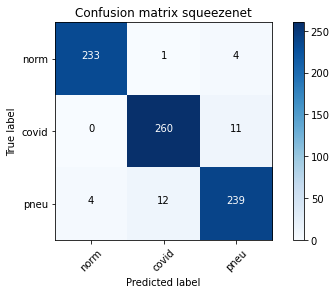

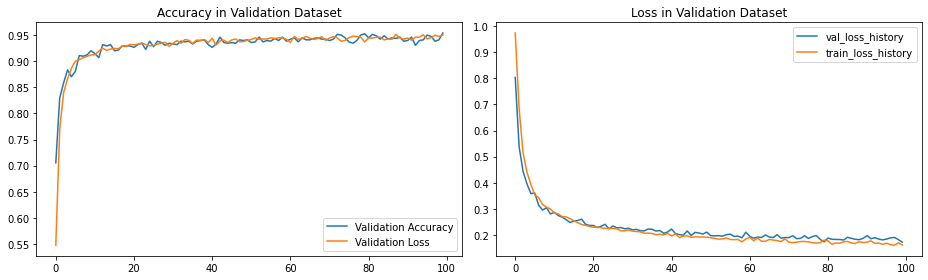


==== END ====
[[233   1   4]
 [  0 255  16]
 [  8  16 231]]

Sensitivity or recall total
0.9410994764397905

Sensitivity or recall per classes
[0.98 0.94 0.91]

Precision
[0.97 0.94 0.92]

F1 Score
[0.97 0.94 0.91]
Confusion matrix, without normalization

TESTE = 16/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.2493 Acc: 0.3416
val Loss: 1.0144 Acc: 0.5170
Epoch 1/99
----------
train Loss: 0.9285 Acc: 0.5748
val Loss: 0.8070 Acc: 0.6702
Epoch 2/99
----------
train Loss: 0.7582 Acc: 0.7412
val Loss: 0.6469 Acc: 0.8285
Epoch 3/99
----------
train Loss: 0.6276 Acc: 0.8228
val Loss: 0.5350 Acc: 0.8508
Epoch 4/99
----------
train Loss: 0.5387 Acc: 0.8595
val Loss: 0.4757 Acc: 0.8743
Epoch 5/99
----------
train Loss: 0.4766 Acc: 0.8713
val Loss: 0.42

train Loss: 0.1286 Acc: 0.9604
val Loss: 0.1492 Acc: 0.9516
Epoch 93/99
----------
train Loss: 0.1322 Acc: 0.9551
val Loss: 0.1656 Acc: 0.9516
Epoch 94/99
----------
train Loss: 0.1276 Acc: 0.9587
val Loss: 0.1644 Acc: 0.9503
Epoch 95/99
----------
train Loss: 0.1256 Acc: 0.9600
val Loss: 0.1460 Acc: 0.9542
Epoch 96/99
----------
train Loss: 0.1288 Acc: 0.9584
val Loss: 0.1485 Acc: 0.9503
Epoch 97/99
----------
train Loss: 0.1281 Acc: 0.9581
val Loss: 0.1542 Acc: 0.9516
Epoch 98/99
----------
train Loss: 0.1322 Acc: 0.9613
val Loss: 0.1508 Acc: 0.9555
Epoch 99/99
----------
train Loss: 0.1272 Acc: 0.9623
val Loss: 0.1525 Acc: 0.9581

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 27m 38s
Best val Acc: 0.958115
##############################


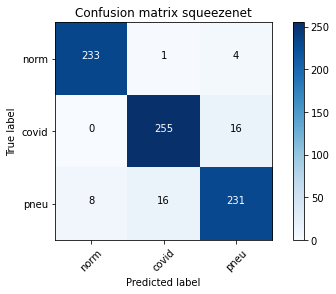

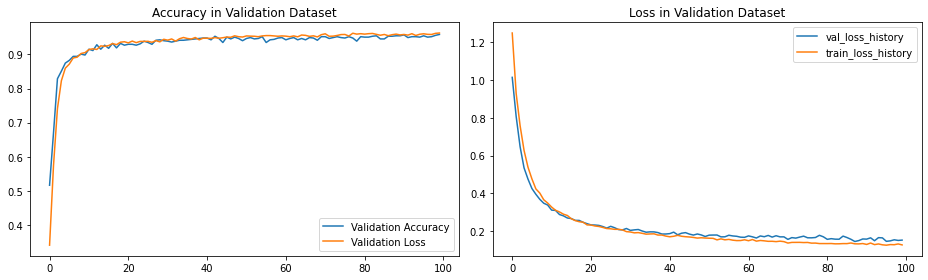


==== END ====
[[234   1   3]
 [  0 258  13]
 [  6  15 234]]

Sensitivity or recall total
0.9502617801047121

Sensitivity or recall per classes
[0.98 0.95 0.92]

Precision
[0.97 0.94 0.94]

F1 Score
[0.98 0.95 0.93]
Confusion matrix, without normalization

TESTE = 17/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.7893 Acc: 0.7019
val Loss: 0.6154 Acc: 0.8168
Epoch 1/99
----------
train Loss: 0.6025 Acc: 0.8081
val Loss: 0.5026 Acc: 0.8613
Epoch 2/99
----------
train Loss: 0.5087 Acc: 0.8542
val Loss: 0.4474 Acc: 0.8730
Epoch 3/99
----------
train Loss: 0.4460 Acc: 0.8755
val Loss: 0.3918 Acc: 0.8914
Epoch 4/99
----------
train Loss: 0.3969 Acc: 0.8850
val Loss: 0.3647 Acc: 0.8914
Epoch 5/99
----------
train Loss: 0.3644 Acc: 0.8975
val Loss: 0.34

train Loss: 0.1267 Acc: 0.9581
val Loss: 0.1575 Acc: 0.9542
Epoch 93/99
----------
train Loss: 0.1238 Acc: 0.9607
val Loss: 0.1574 Acc: 0.9516
Epoch 94/99
----------
train Loss: 0.1318 Acc: 0.9581
val Loss: 0.1492 Acc: 0.9607
Epoch 95/99
----------
train Loss: 0.1230 Acc: 0.9584
val Loss: 0.1623 Acc: 0.9476
Epoch 96/99
----------
train Loss: 0.1232 Acc: 0.9640
val Loss: 0.1568 Acc: 0.9529
Epoch 97/99
----------
train Loss: 0.1231 Acc: 0.9643
val Loss: 0.1527 Acc: 0.9542
Epoch 98/99
----------
train Loss: 0.1228 Acc: 0.9597
val Loss: 0.1539 Acc: 0.9516
Epoch 99/99
----------
train Loss: 0.1240 Acc: 0.9627
val Loss: 0.1573 Acc: 0.9463

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 27m 37s
Best val Acc: 0.960733
##############################


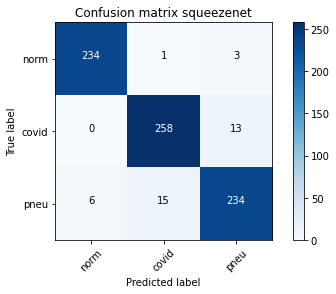

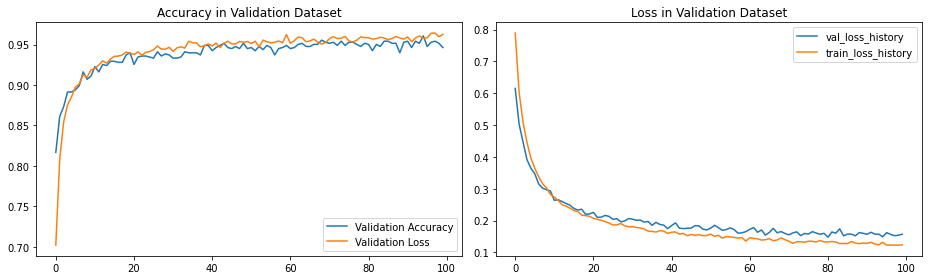


==== END ====
[[233   2   3]
 [  0 258  13]
 [  4  11 240]]

Sensitivity or recall total
0.9568062827225131

Sensitivity or recall per classes
[0.98 0.95 0.94]

Precision
[0.98 0.95 0.94]

F1 Score
[0.98 0.95 0.94]
Confusion matrix, without normalization

TESTE = 18/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0708 Acc: 0.4520
val Loss: 1.0634 Acc: 0.4712
Epoch 1/99
----------
train Loss: 1.0281 Acc: 0.5251
val Loss: 1.0231 Acc: 0.5209
Epoch 2/99
----------
train Loss: 0.9929 Acc: 0.5352
val Loss: 0.9919 Acc: 0.5262
Epoch 3/99
----------
train Loss: 0.9664 Acc: 0.5598
val Loss: 0.9478 Acc: 0.5759
Epoch 4/99
----------
train Loss: 0.9356 Acc: 0.5919
val Loss: 0.9198 Acc: 0.6099
Epoch 5/99
----------
train Loss: 0.9022 Acc: 0.6096
val Loss: 0.8801

train Loss: 0.3039 Acc: 0.9112
val Loss: 0.3004 Acc: 0.9058
Epoch 93/99
----------
train Loss: 0.3120 Acc: 0.9080
val Loss: 0.3053 Acc: 0.8940
Epoch 94/99
----------
train Loss: 0.3091 Acc: 0.9116
val Loss: 0.3032 Acc: 0.9084
Epoch 95/99
----------
train Loss: 0.3091 Acc: 0.9142
val Loss: 0.3003 Acc: 0.9005
Epoch 96/99
----------
train Loss: 0.3049 Acc: 0.9073
val Loss: 0.3043 Acc: 0.9097
Epoch 97/99
----------
train Loss: 0.3039 Acc: 0.9053
val Loss: 0.2968 Acc: 0.8992
Epoch 98/99
----------
train Loss: 0.3008 Acc: 0.9093
val Loss: 0.2847 Acc: 0.9188
Epoch 99/99
----------
train Loss: 0.2998 Acc: 0.9116
val Loss: 0.3025 Acc: 0.9084

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 27m 39s
Best val Acc: 0.918848
##############################


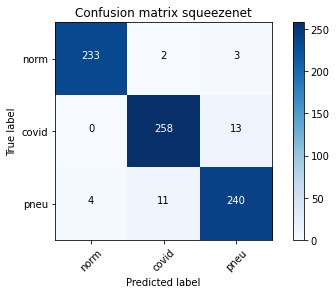

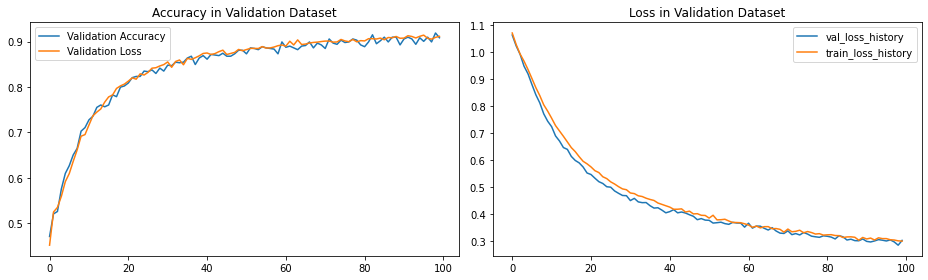


==== END ====
[[228   5   5]
 [  1 247  23]
 [ 14  24 217]]

Sensitivity or recall total
0.9057591623036649

Sensitivity or recall per classes
[0.96 0.91 0.85]

Precision
[0.94 0.89 0.89]

F1 Score
[0.95 0.9  0.87]
Confusion matrix, without normalization

TESTE = 19/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.4381 Acc: 0.2994
val Loss: 1.3256 Acc: 0.3076
Epoch 1/99
----------
train Loss: 1.2840 Acc: 0.3027
val Loss: 1.1983 Acc: 0.3416
Epoch 2/99
----------
train Loss: 1.1839 Acc: 0.3187
val Loss: 1.1357 Acc: 0.3809
Epoch 3/99
----------
train Loss: 1.1352 Acc: 0.3505
val Loss: 1.0911 Acc: 0.3966
Epoch 4/99
----------
train Loss: 1.0997 Acc: 0.3727
val Loss: 1.0618 Acc: 0.4241
Epoch 5/99
----------
train Loss: 1.0799 Acc: 0.3829
val Loss: 1.0328

train Loss: 0.3233 Acc: 0.9139
val Loss: 0.3096 Acc: 0.9123
Epoch 93/99
----------
train Loss: 0.3208 Acc: 0.9112
val Loss: 0.3183 Acc: 0.9031
Epoch 94/99
----------
train Loss: 0.3141 Acc: 0.9168
val Loss: 0.3210 Acc: 0.9110
Epoch 95/99
----------
train Loss: 0.3150 Acc: 0.9106
val Loss: 0.3078 Acc: 0.9110
Epoch 96/99
----------
train Loss: 0.3177 Acc: 0.9086
val Loss: 0.3127 Acc: 0.9123
Epoch 97/99
----------
train Loss: 0.3134 Acc: 0.9099
val Loss: 0.2972 Acc: 0.9215
Epoch 98/99
----------
train Loss: 0.3119 Acc: 0.9139
val Loss: 0.3048 Acc: 0.9149
Epoch 99/99
----------
train Loss: 0.3148 Acc: 0.9112
val Loss: 0.2991 Acc: 0.9123

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 27m 27s
Best val Acc: 0.921466
##############################


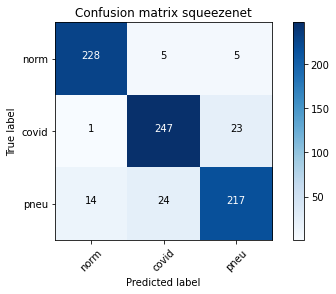

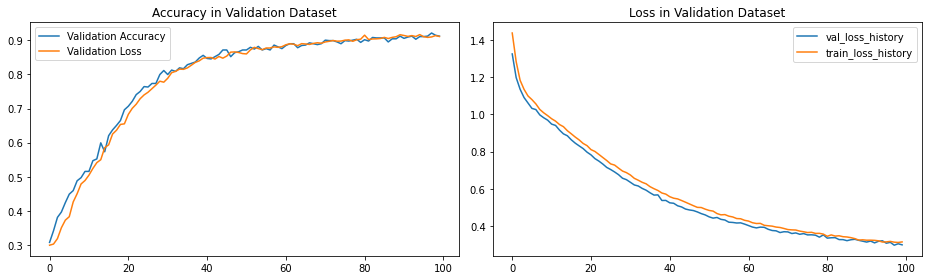


==== END ====
[[222   7   9]
 [  1 254  16]
 [ 13  22 220]]

Sensitivity or recall total
0.9109947643979057

Sensitivity or recall per classes
[0.93 0.94 0.86]

Precision
[0.94 0.9  0.9 ]

F1 Score
[0.94 0.92 0.88]
Confusion matrix, without normalization

TESTE = 20/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0125 Acc: 0.5133
val Loss: 0.9869 Acc: 0.5759
Epoch 1/99
----------
train Loss: 0.9778 Acc: 0.5634
val Loss: 0.9609 Acc: 0.5982
Epoch 2/99
----------
train Loss: 0.9582 Acc: 0.5843
val Loss: 0.9413 Acc: 0.6191
Epoch 3/99
----------
train Loss: 0.9354 Acc: 0.6050
val Loss: 0.9211 Acc: 0.6374
Epoch 4/99
----------
train Loss: 0.9157 Acc: 0.6263
val Loss: 0.8974 Acc: 0.6649
Epoch 5/99
----------
train Loss: 0.9030 Acc: 0.6371
val Loss: 0.8834

train Loss: 0.2968 Acc: 0.9191
val Loss: 0.2994 Acc: 0.9123
Epoch 93/99
----------
train Loss: 0.2953 Acc: 0.9211
val Loss: 0.2850 Acc: 0.9202
Epoch 94/99
----------
train Loss: 0.2967 Acc: 0.9135
val Loss: 0.3026 Acc: 0.9084
Epoch 95/99
----------
train Loss: 0.2934 Acc: 0.9145
val Loss: 0.2854 Acc: 0.9136
Epoch 96/99
----------
train Loss: 0.2918 Acc: 0.9168
val Loss: 0.2873 Acc: 0.9097
Epoch 97/99
----------
train Loss: 0.2840 Acc: 0.9237
val Loss: 0.2944 Acc: 0.9136
Epoch 98/99
----------
train Loss: 0.2834 Acc: 0.9194
val Loss: 0.2878 Acc: 0.9149
Epoch 99/99
----------
train Loss: 0.2813 Acc: 0.9201
val Loss: 0.2803 Acc: 0.9215

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 27m 36s
Best val Acc: 0.921466
##############################


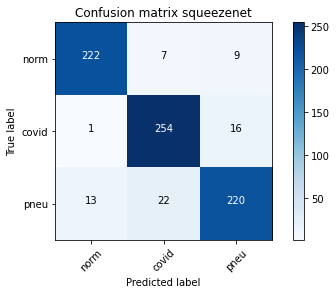

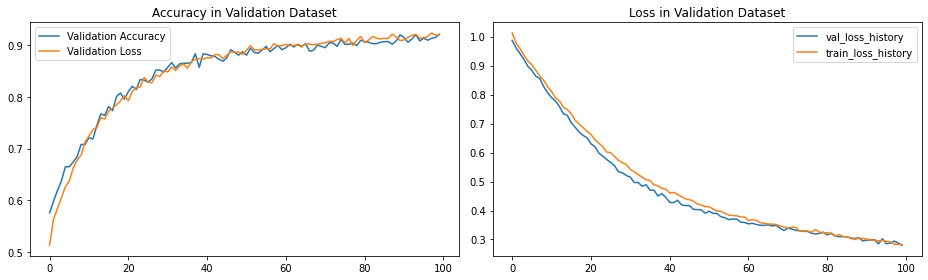


==== END ====
[[221   6  11]
 [  0 249  22]
 [ 12  21 222]]

Sensitivity or recall total
0.9057591623036649

Sensitivity or recall per classes
[0.93 0.92 0.87]

Precision
[0.95 0.9  0.87]

F1 Score
[0.94 0.91 0.87]
Confusion matrix, without normalization

TESTE = 21/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0881 Acc: 0.4219
val Loss: 1.0208 Acc: 0.4843
Epoch 1/99
----------
train Loss: 0.9994 Acc: 0.5002
val Loss: 0.9612 Acc: 0.5510
Epoch 2/99
----------
train Loss: 0.9475 Acc: 0.5634
val Loss: 0.9131 Acc: 0.5903
Epoch 3/99
----------
train Loss: 0.9070 Acc: 0.6076
val Loss: 0.8661 Acc: 0.6387
Epoch 4/99
----------
train Loss: 0.8695 Acc: 0.6384
val Loss: 0.8208 Acc: 0.6741
Epoch 5/99
----------
train Loss: 0.8335 Acc: 0.6666
val Loss: 0.773

train Loss: 0.2984 Acc: 0.9112
val Loss: 0.2963 Acc: 0.9084
Epoch 93/99
----------
train Loss: 0.3004 Acc: 0.9122
val Loss: 0.2949 Acc: 0.9110
Epoch 94/99
----------
train Loss: 0.2897 Acc: 0.9112
val Loss: 0.2872 Acc: 0.9162
Epoch 95/99
----------
train Loss: 0.2913 Acc: 0.9155
val Loss: 0.2849 Acc: 0.9071
Epoch 96/99
----------
train Loss: 0.2893 Acc: 0.9148
val Loss: 0.2831 Acc: 0.9123
Epoch 97/99
----------
train Loss: 0.2923 Acc: 0.9135
val Loss: 0.2836 Acc: 0.9136
Epoch 98/99
----------
train Loss: 0.2869 Acc: 0.9152
val Loss: 0.2727 Acc: 0.9202
Epoch 99/99
----------
train Loss: 0.2881 Acc: 0.9132
val Loss: 0.2899 Acc: 0.8953

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 27m 34s
Best val Acc: 0.920157
##############################


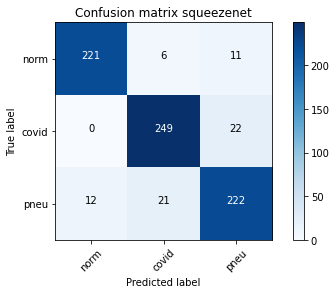

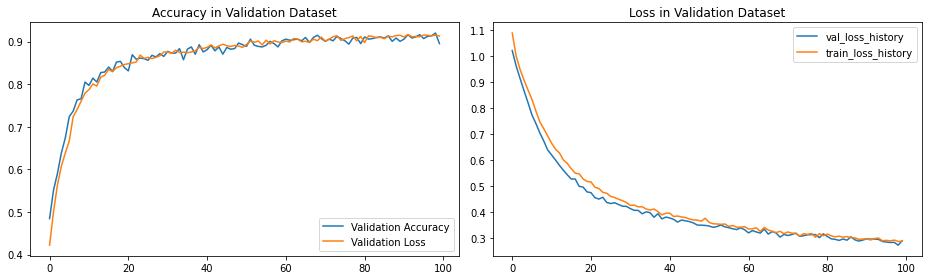


==== END ====
[[229   3   6]
 [  0 250  21]
 [ 15  24 216]]

Sensitivity or recall total
0.9096858638743456

Sensitivity or recall per classes
[0.96 0.92 0.85]

Precision
[0.94 0.9  0.89]

F1 Score
[0.95 0.91 0.87]
Confusion matrix, without normalization

TESTE = 22/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0976 Acc: 0.3754
val Loss: 1.0593 Acc: 0.3979
Epoch 1/99
----------
train Loss: 1.0424 Acc: 0.4232
val Loss: 1.0129 Acc: 0.4568
Epoch 2/99
----------
train Loss: 1.0030 Acc: 0.4844
val Loss: 0.9794 Acc: 0.5393
Epoch 3/99
----------
train Loss: 0.9849 Acc: 0.5179
val Loss: 0.9564 Acc: 0.5877
Epoch 4/99
----------
train Loss: 0.9594 Acc: 0.5680
val Loss: 0.9281 Acc: 0.6178
Epoch 5/99
----------
train Loss: 0.9349 Acc: 0.6066
val Loss: 0.904

train Loss: 0.3186 Acc: 0.9099
val Loss: 0.3223 Acc: 0.8992
Epoch 93/99
----------
train Loss: 0.3167 Acc: 0.9066
val Loss: 0.3136 Acc: 0.8992
Epoch 94/99
----------
train Loss: 0.3146 Acc: 0.9132
val Loss: 0.3164 Acc: 0.9071
Epoch 95/99
----------
train Loss: 0.3150 Acc: 0.9096
val Loss: 0.3166 Acc: 0.8979
Epoch 96/99
----------
train Loss: 0.3099 Acc: 0.9096
val Loss: 0.3127 Acc: 0.9018
Epoch 97/99
----------
train Loss: 0.3079 Acc: 0.9050
val Loss: 0.3067 Acc: 0.9005
Epoch 98/99
----------
train Loss: 0.3149 Acc: 0.9024
val Loss: 0.3053 Acc: 0.8979
Epoch 99/99
----------
train Loss: 0.3099 Acc: 0.9145
val Loss: 0.3121 Acc: 0.9005

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 27m 35s
Best val Acc: 0.907068
##############################


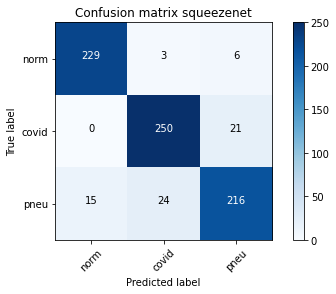

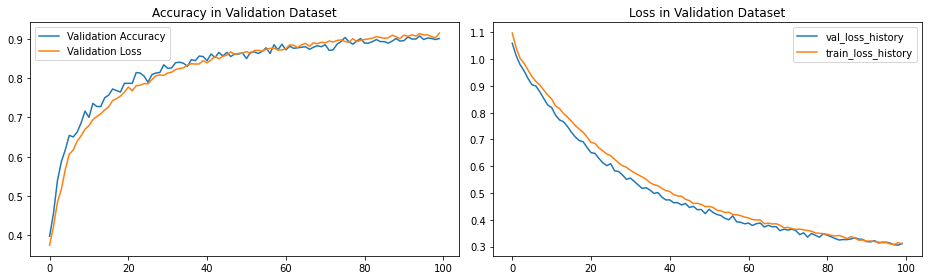


==== END ====
[[223   7   8]
 [  1 247  23]
 [ 13  23 219]]

Sensitivity or recall total
0.9018324607329843

Sensitivity or recall per classes
[0.94 0.91 0.86]

Precision
[0.94 0.89 0.88]

F1 Score
[0.94 0.9  0.87]
Confusion matrix, without normalization

TESTE = 23/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.1135 Acc: 0.3567
val Loss: 1.0864 Acc: 0.3429
Epoch 1/99
----------
train Loss: 1.0415 Acc: 0.4481
val Loss: 1.0362 Acc: 0.4476
Epoch 2/99
----------
train Loss: 1.0046 Acc: 0.5267
val Loss: 1.0046 Acc: 0.5105
Epoch 3/99
----------
train Loss: 0.9817 Acc: 0.5572
val Loss: 0.9730 Acc: 0.5628
Epoch 4/99
----------
train Loss: 0.9639 Acc: 0.5794
val Loss: 0.9528 Acc: 0.5772
Epoch 5/99
----------
train Loss: 0.9456 Acc: 0.5935
val Loss: 0.935

train Loss: 0.3085 Acc: 0.9152
val Loss: 0.3056 Acc: 0.9123
Epoch 93/99
----------
train Loss: 0.3041 Acc: 0.9165
val Loss: 0.3048 Acc: 0.9058
Epoch 94/99
----------
train Loss: 0.3025 Acc: 0.9198
val Loss: 0.2919 Acc: 0.9175
Epoch 95/99
----------
train Loss: 0.3032 Acc: 0.9152
val Loss: 0.3009 Acc: 0.9110
Epoch 96/99
----------
train Loss: 0.2971 Acc: 0.9142
val Loss: 0.2903 Acc: 0.9110
Epoch 97/99
----------
train Loss: 0.3023 Acc: 0.9106
val Loss: 0.2930 Acc: 0.9071
Epoch 98/99
----------
train Loss: 0.2894 Acc: 0.9224
val Loss: 0.2854 Acc: 0.9175
Epoch 99/99
----------
train Loss: 0.2926 Acc: 0.9227
val Loss: 0.2881 Acc: 0.9228

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 27m 34s
Best val Acc: 0.922775
##############################


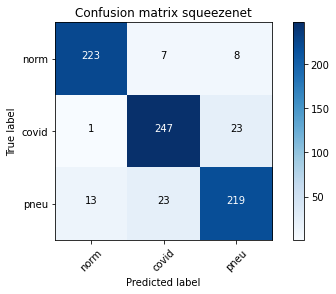

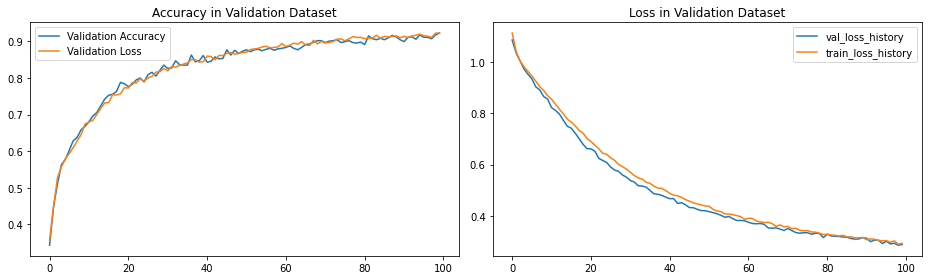


==== END ====
[[228   5   5]
 [  0 253  18]
 [ 12  24 219]]

Sensitivity or recall total
0.9162303664921466

Sensitivity or recall per classes
[0.96 0.93 0.86]

Precision
[0.95 0.9  0.9 ]

F1 Score
[0.95 0.92 0.88]
Confusion matrix, without normalization

TESTE = 24/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0524 Acc: 0.4677
val Loss: 0.9871 Acc: 0.5196
Epoch 1/99
----------
train Loss: 0.9820 Acc: 0.5372
val Loss: 0.9376 Acc: 0.5668
Epoch 2/99
----------
train Loss: 0.9273 Acc: 0.5840
val Loss: 0.8723 Acc: 0.6270
Epoch 3/99
----------
train Loss: 0.8805 Acc: 0.6233
val Loss: 0.8227 Acc: 0.6728
Epoch 4/99
----------
train Loss: 0.8342 Acc: 0.6666
val Loss: 0.7700 Acc: 0.7068
Epoch 5/99
----------
train Loss: 0.7849 Acc: 0.7003
val Loss: 0.719

train Loss: 0.2936 Acc: 0.9132
val Loss: 0.2824 Acc: 0.9241
Epoch 93/99
----------
train Loss: 0.2912 Acc: 0.9178
val Loss: 0.2881 Acc: 0.9110
Epoch 94/99
----------
train Loss: 0.2916 Acc: 0.9188
val Loss: 0.2921 Acc: 0.9058
Epoch 95/99
----------
train Loss: 0.2936 Acc: 0.9139
val Loss: 0.3029 Acc: 0.8992
Epoch 96/99
----------
train Loss: 0.2919 Acc: 0.9122
val Loss: 0.2919 Acc: 0.9071
Epoch 97/99
----------
train Loss: 0.2934 Acc: 0.9142
val Loss: 0.2874 Acc: 0.9071
Epoch 98/99
----------
train Loss: 0.2898 Acc: 0.9139
val Loss: 0.2826 Acc: 0.9162
Epoch 99/99
----------
train Loss: 0.2839 Acc: 0.9135
val Loss: 0.2815 Acc: 0.9097

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 27m 35s
Best val Acc: 0.924084
##############################


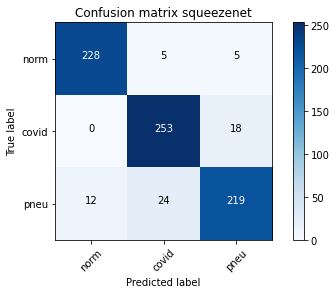

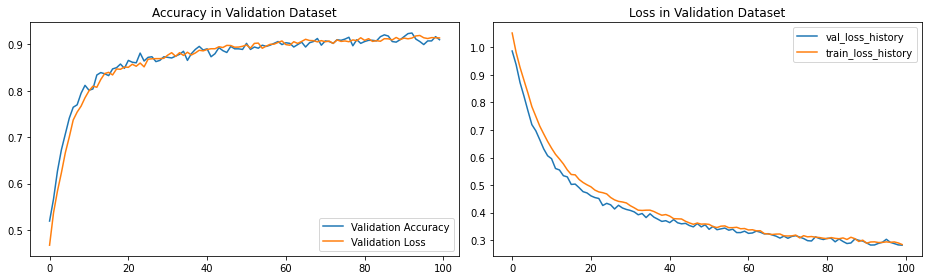


==== END ====
[[227   3   8]
 [  1 247  23]
 [  9  22 224]]

Sensitivity or recall total
0.9136125654450262

Sensitivity or recall per classes
[0.95 0.91 0.88]

Precision
[0.96 0.91 0.88]

F1 Score
[0.96 0.91 0.88]
Confusion matrix, without normalization

TESTE = 25/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.1969 Acc: 0.3921
val Loss: 1.1668 Acc: 0.4188
Epoch 1/99
----------
train Loss: 1.1533 Acc: 0.4094
val Loss: 1.1511 Acc: 0.4058
Epoch 2/99
----------
train Loss: 1.1160 Acc: 0.4183
val Loss: 1.1266 Acc: 0.4123
Epoch 3/99
----------
train Loss: 1.0901 Acc: 0.4183
val Loss: 1.1037 Acc: 0.3887
Epoch 4/99
----------
train Loss: 1.0679 Acc: 0.4386
val Loss: 1.0901 Acc: 0.4045
Epoch 5/99
----------
train Loss: 1.0468 Acc: 0.4615
val Loss: 1.070

train Loss: 0.2979 Acc: 0.9234
val Loss: 0.2941 Acc: 0.9136
Epoch 93/99
----------
train Loss: 0.3003 Acc: 0.9188
val Loss: 0.3062 Acc: 0.9058
Epoch 94/99
----------
train Loss: 0.2992 Acc: 0.9171
val Loss: 0.3002 Acc: 0.9188
Epoch 95/99
----------
train Loss: 0.2929 Acc: 0.9148
val Loss: 0.3003 Acc: 0.9097
Epoch 96/99
----------
train Loss: 0.2956 Acc: 0.9243
val Loss: 0.2962 Acc: 0.9110
Epoch 97/99
----------
train Loss: 0.2843 Acc: 0.9292
val Loss: 0.3019 Acc: 0.9084
Epoch 98/99
----------
train Loss: 0.2889 Acc: 0.9237
val Loss: 0.2907 Acc: 0.9110
Epoch 99/99
----------
train Loss: 0.2898 Acc: 0.9201
val Loss: 0.2955 Acc: 0.9215

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 27m 34s
Best val Acc: 0.921466
##############################


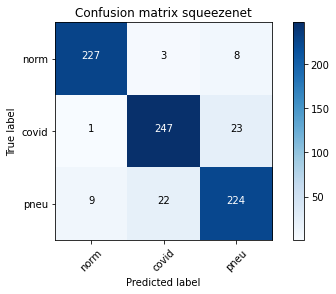

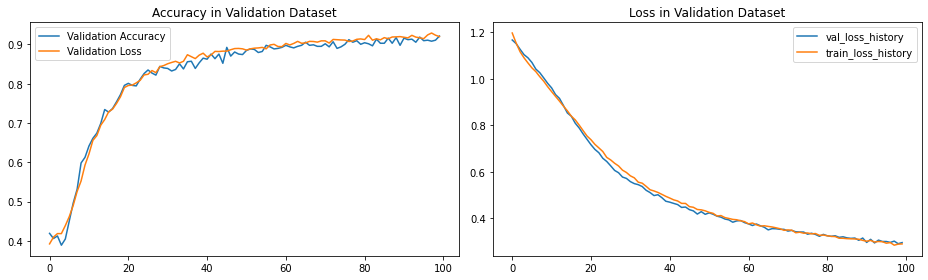


==== END ====
[[228   2   8]
 [  0 249  22]
 [ 13  18 224]]

Sensitivity or recall total
0.9175392670157068

Sensitivity or recall per classes
[0.96 0.92 0.88]

Precision
[0.95 0.93 0.88]

F1 Score
[0.95 0.92 0.88]
Confusion matrix, without normalization

TESTE = 26/54

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.2143 Acc: 0.3164
val Loss: 1.1574 Acc: 0.3102
Epoch 1/99
----------
train Loss: 1.1501 Acc: 0.3046
val Loss: 1.1192 Acc: 0.2866
Epoch 2/99
----------
train Loss: 1.1209 Acc: 0.3020
val Loss: 1.1073 Acc: 0.2880
Epoch 3/99
----------
train Loss: 1.1035 Acc: 0.3308
val Loss: 1.0862 Acc: 0.3037
Epoch 4/99
----------
train Loss: 1.0827 Acc: 0.3629
val Loss: 1.0696 Acc: 0.3665
Epoch 5/99
----------
train Loss: 1.0666 Acc: 0.4022
val Loss: 1.054

train Loss: 0.3085 Acc: 0.9161
val Loss: 0.2995 Acc: 0.9097
Epoch 93/99
----------
train Loss: 0.3080 Acc: 0.9142
val Loss: 0.2914 Acc: 0.9136
Epoch 94/99
----------
train Loss: 0.3022 Acc: 0.9188
val Loss: 0.2904 Acc: 0.9045
Epoch 95/99
----------
train Loss: 0.2978 Acc: 0.9168
val Loss: 0.2932 Acc: 0.9084
Epoch 96/99
----------
train Loss: 0.2983 Acc: 0.9201
val Loss: 0.2883 Acc: 0.9123
Epoch 97/99
----------
train Loss: 0.3002 Acc: 0.9191
val Loss: 0.2942 Acc: 0.9071
Epoch 98/99
----------
train Loss: 0.2972 Acc: 0.9188
val Loss: 0.2967 Acc: 0.9175
Epoch 99/99
----------
train Loss: 0.2986 Acc: 0.9155
val Loss: 0.2822 Acc: 0.9175

##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 27m 38s
Best val Acc: 0.917539
##############################


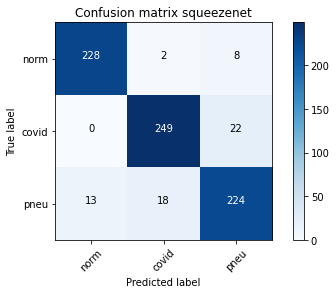

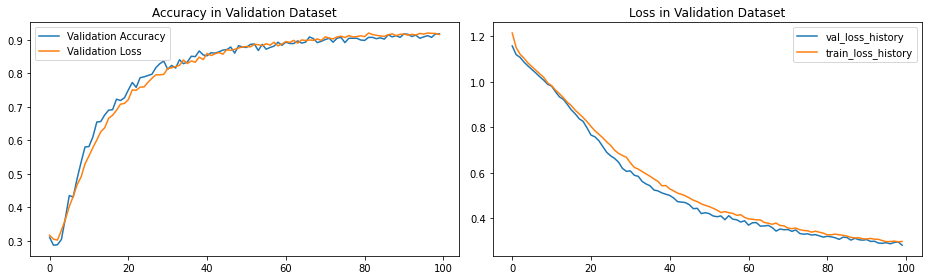


==== END ====
[[225   5   8]
 [  1 249  21]
 [ 10  24 221]]

Sensitivity or recall total
0.9096858638743456

Sensitivity or recall per classes
[0.95 0.92 0.87]

Precision
[0.95 0.9  0.88]

F1 Score
[0.95 0.91 0.88]
Confusion matrix, without normalization

TESTE = 27/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5607 Acc: 0.7976
val Loss: 0.2899 Acc: 0.9280
Epoch 1/99
----------
train Loss: 0.2725 Acc: 0.9234
val Loss: 0.2368 Acc: 0.9202
Epoch 2/99
----------
train Loss: 0.2245 Acc: 0.9387
val Loss: 0.2038 Acc: 0.9398
Epoch 3/99
----------
train Loss: 0.2116 Acc: 0.9374
val Loss: 0.1828 Acc: 0.9503
Epoch 4/99
----------
train Loss: 0.1964 Acc: 0.9384
val Loss: 0.1732 Acc: 0.9450
Epoch 5/99
----------
train Loss: 0.1891 Acc: 0.9394
val Loss: 0.1749 Acc: 

train Loss: 0.1110 Acc: 0.9600
val Loss: 0.1274 Acc: 0.9634
Epoch 93/99
----------
train Loss: 0.1105 Acc: 0.9630
val Loss: 0.1245 Acc: 0.9620
Epoch 94/99
----------
train Loss: 0.1118 Acc: 0.9587
val Loss: 0.1078 Acc: 0.9581
Epoch 95/99
----------
train Loss: 0.1138 Acc: 0.9610
val Loss: 0.0932 Acc: 0.9673
Epoch 96/99
----------
train Loss: 0.1197 Acc: 0.9568
val Loss: 0.1060 Acc: 0.9647
Epoch 97/99
----------
train Loss: 0.1102 Acc: 0.9627
val Loss: 0.1164 Acc: 0.9607
Epoch 98/99
----------
train Loss: 0.1223 Acc: 0.9558
val Loss: 0.1040 Acc: 0.9620
Epoch 99/99
----------
train Loss: 0.1235 Acc: 0.9512
val Loss: 0.1107 Acc: 0.9607

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 29m 48s
Best val Acc: 0.967277
##############################


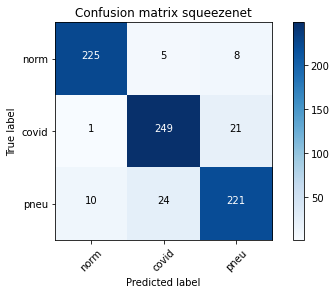

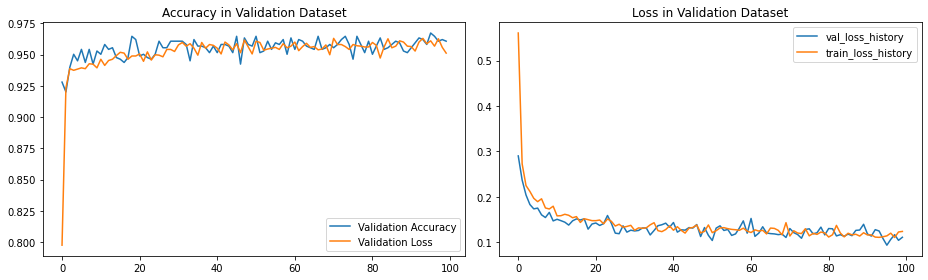


==== END ====
[[235   1   2]
 [  0 258  13]
 [  3   7 245]]

Sensitivity or recall total
0.9659685863874345

Sensitivity or recall per classes
[0.99 0.95 0.96]

Precision
[0.99 0.97 0.94]

F1 Score
[0.99 0.96 0.95]
Confusion matrix, without normalization

TESTE = 28/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5774 Acc: 0.7917
val Loss: 0.3196 Acc: 0.9202
Epoch 1/99
----------
train Loss: 0.2898 Acc: 0.9204
val Loss: 0.2261 Acc: 0.9228
Epoch 2/99
----------
train Loss: 0.2372 Acc: 0.9270
val Loss: 0.2185 Acc: 0.9372
Epoch 3/99
----------
train Loss: 0.2170 Acc: 0.9322
val Loss: 0.1881 Acc: 0.9385
Epoch 4/99
----------
train Loss: 0.1992 Acc: 0.9348
val Loss: 0.1658 Acc: 0.9490
Epoch 5/99
----------
train Loss: 0.1722 Acc: 0.9440
val Loss: 0.1516 Acc: 

train Loss: 0.0991 Acc: 0.9627
val Loss: 0.1038 Acc: 0.9634
Epoch 93/99
----------
train Loss: 0.1179 Acc: 0.9538
val Loss: 0.1197 Acc: 0.9555
Epoch 94/99
----------
train Loss: 0.1187 Acc: 0.9581
val Loss: 0.1261 Acc: 0.9581
Epoch 95/99
----------
train Loss: 0.1058 Acc: 0.9617
val Loss: 0.1438 Acc: 0.9476
Epoch 96/99
----------
train Loss: 0.1104 Acc: 0.9564
val Loss: 0.1233 Acc: 0.9542
Epoch 97/99
----------
train Loss: 0.1005 Acc: 0.9653
val Loss: 0.1062 Acc: 0.9581
Epoch 98/99
----------
train Loss: 0.1138 Acc: 0.9581
val Loss: 0.1138 Acc: 0.9620
Epoch 99/99
----------
train Loss: 0.1033 Acc: 0.9633
val Loss: 0.1144 Acc: 0.9686

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 29m 56s
Best val Acc: 0.972513
##############################


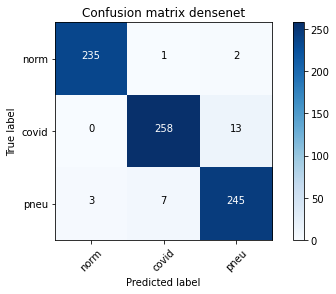

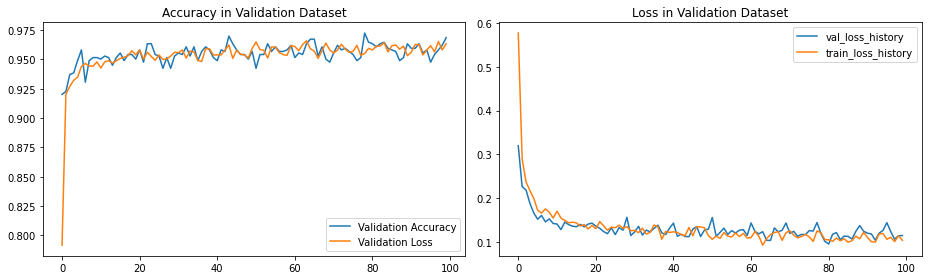


==== END ====
[[235   1   2]
 [  0 254  17]
 [  1  10 244]]

Sensitivity or recall total
0.9594240837696335

Sensitivity or recall per classes
[0.99 0.94 0.96]

Precision
[1.   0.96 0.93]

F1 Score
[0.99 0.95 0.94]
Confusion matrix, without normalization

TESTE = 29/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5198 Acc: 0.8431
val Loss: 0.2987 Acc: 0.8940
Epoch 1/99
----------
train Loss: 0.2671 Acc: 0.9161
val Loss: 0.2703 Acc: 0.9005
Epoch 2/99
----------
train Loss: 0.2404 Acc: 0.9188
val Loss: 0.2128 Acc: 0.9332
Epoch 3/99
----------
train Loss: 0.2149 Acc: 0.9371
val Loss: 0.1859 Acc: 0.9450
Epoch 4/99
----------
train Loss: 0.1913 Acc: 0.9387
val Loss: 0.1640 Acc: 0.9516
Epoch 5/99
----------
train Loss: 0.1766 Acc: 0.9404
val Loss: 0.1514 Acc: 

train Loss: 0.0978 Acc: 0.9627
val Loss: 0.0942 Acc: 0.9568
Epoch 93/99
----------
train Loss: 0.1089 Acc: 0.9620
val Loss: 0.1851 Acc: 0.9385
Epoch 94/99
----------
train Loss: 0.1019 Acc: 0.9607
val Loss: 0.1138 Acc: 0.9555
Epoch 95/99
----------
train Loss: 0.1089 Acc: 0.9591
val Loss: 0.1377 Acc: 0.9555
Epoch 96/99
----------
train Loss: 0.1056 Acc: 0.9571
val Loss: 0.1242 Acc: 0.9620
Epoch 97/99
----------
train Loss: 0.1229 Acc: 0.9574
val Loss: 0.1267 Acc: 0.9634
Epoch 98/99
----------
train Loss: 0.1074 Acc: 0.9587
val Loss: 0.1325 Acc: 0.9542
Epoch 99/99
----------
train Loss: 0.1287 Acc: 0.9522
val Loss: 0.1021 Acc: 0.9620

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 8
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 30m 7s
Best val Acc: 0.973822
##############################


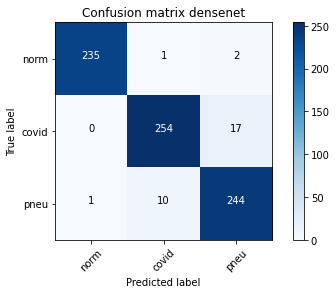

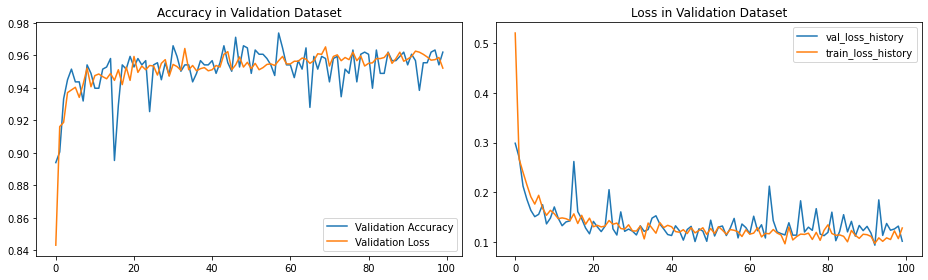


==== END ====
[[233   2   3]
 [  1 257  13]
 [  1  12 242]]

Sensitivity or recall total
0.9581151832460733

Sensitivity or recall per classes
[0.98 0.95 0.95]

Precision
[0.99 0.95 0.94]

F1 Score
[0.99 0.95 0.94]
Confusion matrix, without normalization

TESTE = 30/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5490 Acc: 0.8123
val Loss: 0.3025 Acc: 0.9162
Epoch 1/99
----------
train Loss: 0.2839 Acc: 0.9188
val Loss: 0.2292 Acc: 0.9346
Epoch 2/99
----------
train Loss: 0.2459 Acc: 0.9227
val Loss: 0.2005 Acc: 0.9359
Epoch 3/99
----------
train Loss: 0.2012 Acc: 0.9345
val Loss: 0.1844 Acc: 0.9359
Epoch 4/99
----------
train Loss: 0.2016 Acc: 0.9348
val Loss: 0.1635 Acc: 0.9490
Epoch 5/99
----------
train Loss: 0.1861 Acc: 0.9430
val Loss: 0.1615 Acc:

train Loss: 0.1185 Acc: 0.9561
val Loss: 0.1195 Acc: 0.9568
Epoch 93/99
----------
train Loss: 0.1125 Acc: 0.9545
val Loss: 0.1256 Acc: 0.9581
Epoch 94/99
----------
train Loss: 0.1308 Acc: 0.9525
val Loss: 0.1182 Acc: 0.9581
Epoch 95/99
----------
train Loss: 0.1097 Acc: 0.9597
val Loss: 0.1154 Acc: 0.9529
Epoch 96/99
----------
train Loss: 0.1131 Acc: 0.9610
val Loss: 0.1318 Acc: 0.9568
Epoch 97/99
----------
train Loss: 0.1178 Acc: 0.9600
val Loss: 0.1150 Acc: 0.9542
Epoch 98/99
----------
train Loss: 0.1182 Acc: 0.9577
val Loss: 0.1125 Acc: 0.9634
Epoch 99/99
----------
train Loss: 0.1199 Acc: 0.9561
val Loss: 0.1354 Acc: 0.9516

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 30m 3s
Best val Acc: 0.972513
##############################


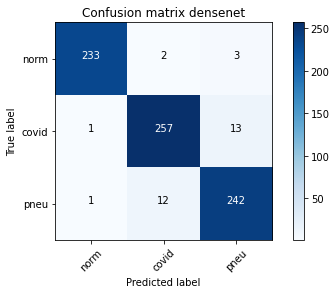

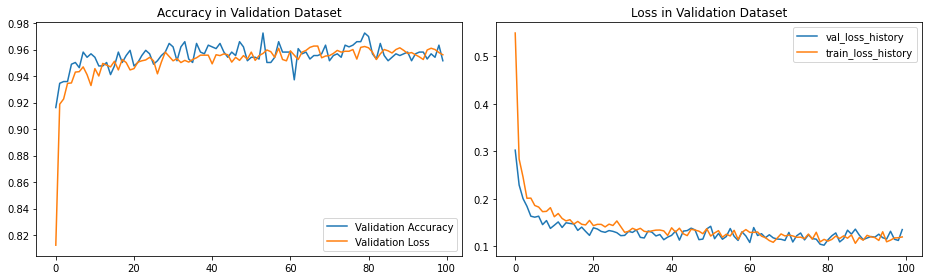


==== END ====
[[233   2   3]
 [  0 255  16]
 [  0  14 241]]

Sensitivity or recall total
0.9541884816753927

Sensitivity or recall per classes
[0.98 0.94 0.95]

Precision
[1.   0.94 0.93]

F1 Score
[0.99 0.94 0.94]
Confusion matrix, without normalization

TESTE = 31/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5230 Acc: 0.8434
val Loss: 0.2809 Acc: 0.9319
Epoch 1/99
----------
train Loss: 0.2781 Acc: 0.9181
val Loss: 0.2195 Acc: 0.9346
Epoch 2/99
----------
train Loss: 0.2258 Acc: 0.9296
val Loss: 0.1951 Acc: 0.9503
Epoch 3/99
----------
train Loss: 0.2060 Acc: 0.9299
val Loss: 0.1789 Acc: 0.9437
Epoch 4/99
----------
train Loss: 0.1839 Acc: 0.9414
val Loss: 0.1579 Acc: 0.9581
Epoch 5/99
----------
train Loss: 0.1853 Acc: 0.9387
val Loss: 0.1587 Acc:

train Loss: 0.0968 Acc: 0.9643
val Loss: 0.1068 Acc: 0.9542
Epoch 93/99
----------
train Loss: 0.1258 Acc: 0.9522
val Loss: 0.1225 Acc: 0.9568
Epoch 94/99
----------
train Loss: 0.1095 Acc: 0.9577
val Loss: 0.1064 Acc: 0.9607
Epoch 95/99
----------
train Loss: 0.1127 Acc: 0.9597
val Loss: 0.1179 Acc: 0.9594
Epoch 96/99
----------
train Loss: 0.1108 Acc: 0.9591
val Loss: 0.1202 Acc: 0.9607
Epoch 97/99
----------
train Loss: 0.1127 Acc: 0.9627
val Loss: 0.1341 Acc: 0.9594
Epoch 98/99
----------
train Loss: 0.1140 Acc: 0.9587
val Loss: 0.1274 Acc: 0.9555
Epoch 99/99
----------
train Loss: 0.1128 Acc: 0.9581
val Loss: 0.1338 Acc: 0.9607

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 30m 4s
Best val Acc: 0.976440
##############################


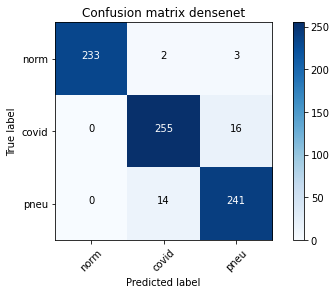

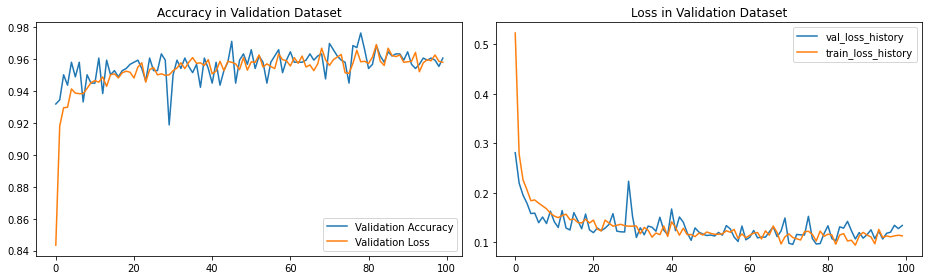


==== END ====
[[232   2   4]
 [  0 264   7]
 [  0   9 246]]

Sensitivity or recall total
0.9712041884816754

Sensitivity or recall per classes
[0.97 0.97 0.96]

Precision
[1.   0.96 0.96]

F1 Score
[0.99 0.97 0.96]
Confusion matrix, without normalization

TESTE = 32/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4909 Acc: 0.8438
val Loss: 0.2838 Acc: 0.9045
Epoch 1/99
----------
train Loss: 0.2654 Acc: 0.9184
val Loss: 0.2956 Acc: 0.8966
Epoch 2/99
----------
train Loss: 0.2349 Acc: 0.9260
val Loss: 0.1850 Acc: 0.9385
Epoch 3/99
----------
train Loss: 0.2106 Acc: 0.9348
val Loss: 0.1691 Acc: 0.9372
Epoch 4/99
----------
train Loss: 0.1941 Acc: 0.9355
val Loss: 0.2556 Acc: 0.9149
Epoch 5/99
----------
train Loss: 0.1874 Acc: 0.9319
val Loss: 0.2825 Acc:

train Loss: 0.1070 Acc: 0.9591
val Loss: 0.1193 Acc: 0.9581
Epoch 93/99
----------
train Loss: 0.1257 Acc: 0.9545
val Loss: 0.1093 Acc: 0.9686
Epoch 94/99
----------
train Loss: 0.1107 Acc: 0.9587
val Loss: 0.1157 Acc: 0.9568
Epoch 95/99
----------
train Loss: 0.1114 Acc: 0.9568
val Loss: 0.1853 Acc: 0.9359
Epoch 96/99
----------
train Loss: 0.1106 Acc: 0.9591
val Loss: 0.0964 Acc: 0.9712
Epoch 97/99
----------
train Loss: 0.1155 Acc: 0.9587
val Loss: 0.1562 Acc: 0.9490
Epoch 98/99
----------
train Loss: 0.1046 Acc: 0.9613
val Loss: 0.1216 Acc: 0.9634
Epoch 99/99
----------
train Loss: 0.1151 Acc: 0.9564
val Loss: 0.1254 Acc: 0.9542

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 16
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 30m 10s
Best val Acc: 0.971204
##############################


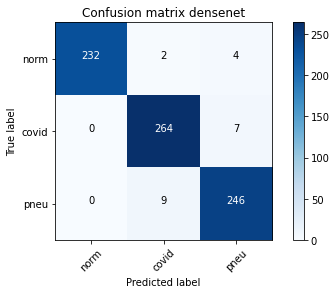

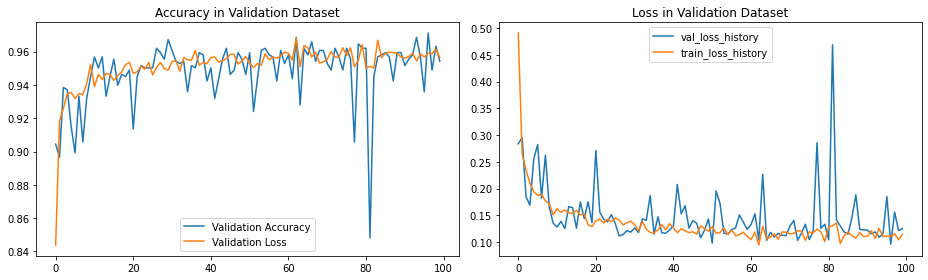


==== END ====
[[235   2   1]
 [  0 255  16]
 [  2   6 247]]

Sensitivity or recall total
0.9646596858638743

Sensitivity or recall per classes
[0.99 0.94 0.97]

Precision
[0.99 0.97 0.94]

F1 Score
[0.99 0.96 0.95]
Confusion matrix, without normalization

TESTE = 33/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5403 Acc: 0.8166
val Loss: 0.2888 Acc: 0.9215
Epoch 1/99
----------
train Loss: 0.2725 Acc: 0.9230
val Loss: 0.2302 Acc: 0.9306
Epoch 2/99
----------
train Loss: 0.2389 Acc: 0.9286
val Loss: 0.2052 Acc: 0.9411
Epoch 3/99
----------
train Loss: 0.2112 Acc: 0.9322
val Loss: 0.1820 Acc: 0.9437
Epoch 4/99
----------
train Loss: 0.1974 Acc: 0.9387
val Loss: 0.1770 Acc: 0.9424
Epoch 5/99
----------
train Loss: 0.1914 Acc: 0.9407
val Loss: 0.1540 Acc:

train Loss: 0.1106 Acc: 0.9620
val Loss: 0.1398 Acc: 0.9516
Epoch 93/99
----------
train Loss: 0.1183 Acc: 0.9561
val Loss: 0.1085 Acc: 0.9673
Epoch 94/99
----------
train Loss: 0.1150 Acc: 0.9600
val Loss: 0.1278 Acc: 0.9568
Epoch 95/99
----------
train Loss: 0.1152 Acc: 0.9587
val Loss: 0.1392 Acc: 0.9555
Epoch 96/99
----------
train Loss: 0.1184 Acc: 0.9571
val Loss: 0.1204 Acc: 0.9634
Epoch 97/99
----------
train Loss: 0.1160 Acc: 0.9587
val Loss: 0.1121 Acc: 0.9581
Epoch 98/99
----------
train Loss: 0.1118 Acc: 0.9594
val Loss: 0.1292 Acc: 0.9555
Epoch 99/99
----------
train Loss: 0.1029 Acc: 0.9627
val Loss: 0.1290 Acc: 0.9581

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 30m 11s
Best val Acc: 0.968586
##############################


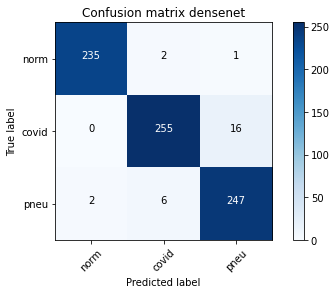

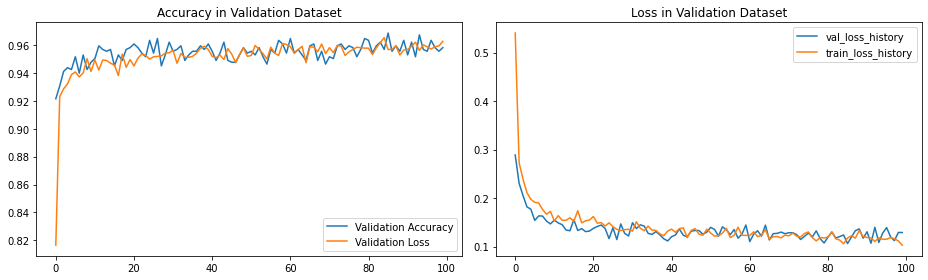


==== END ====
[[235   1   2]
 [  0 257  14]
 [  2  10 243]]

Sensitivity or recall total
0.9620418848167539

Sensitivity or recall per classes
[0.99 0.95 0.95]

Precision
[0.99 0.96 0.94]

F1 Score
[0.99 0.95 0.95]
Confusion matrix, without normalization

TESTE = 34/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5676 Acc: 0.8156
val Loss: 0.2979 Acc: 0.9254
Epoch 1/99
----------
train Loss: 0.2770 Acc: 0.9234
val Loss: 0.2172 Acc: 0.9306
Epoch 2/99
----------
train Loss: 0.2180 Acc: 0.9358
val Loss: 0.1874 Acc: 0.9346
Epoch 3/99
----------
train Loss: 0.1977 Acc: 0.9361
val Loss: 0.1659 Acc: 0.9463
Epoch 4/99
----------
train Loss: 0.1861 Acc: 0.9374
val Loss: 0.1609 Acc: 0.9529
Epoch 5/99
----------
train Loss: 0.1805 Acc: 0.9378
val Loss: 0.1566 Acc:

train Loss: 0.0995 Acc: 0.9627
val Loss: 0.1132 Acc: 0.9634
Epoch 93/99
----------
train Loss: 0.0948 Acc: 0.9643
val Loss: 0.1114 Acc: 0.9568
Epoch 94/99
----------
train Loss: 0.1043 Acc: 0.9627
val Loss: 0.1124 Acc: 0.9594
Epoch 95/99
----------
train Loss: 0.1026 Acc: 0.9630
val Loss: 0.1076 Acc: 0.9647
Epoch 96/99
----------
train Loss: 0.1097 Acc: 0.9597
val Loss: 0.1264 Acc: 0.9581
Epoch 97/99
----------
train Loss: 0.1075 Acc: 0.9640
val Loss: 0.1172 Acc: 0.9660
Epoch 98/99
----------
train Loss: 0.1045 Acc: 0.9564
val Loss: 0.1071 Acc: 0.9647
Epoch 99/99
----------
train Loss: 0.0989 Acc: 0.9617
val Loss: 0.1116 Acc: 0.9555

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 30m 9s
Best val Acc: 0.972513
##############################


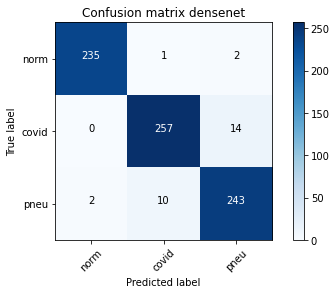

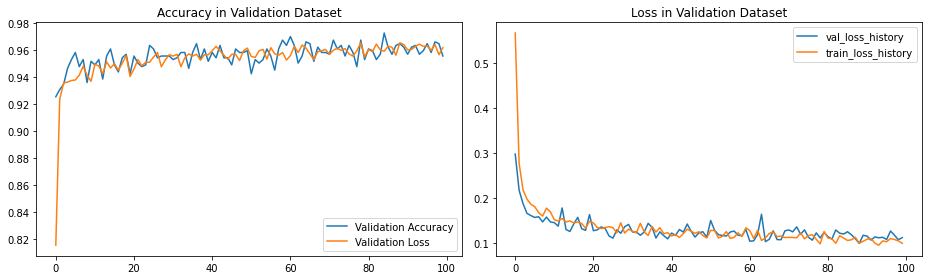


==== END ====
[[231   1   6]
 [  0 261  10]
 [  1  11 243]]

Sensitivity or recall total
0.9620418848167539

Sensitivity or recall per classes
[0.97 0.96 0.95]

Precision
[1.   0.96 0.94]

F1 Score
[0.98 0.96 0.95]
Confusion matrix, without normalization

TESTE = 35/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5625 Acc: 0.8051
val Loss: 0.3027 Acc: 0.9097
Epoch 1/99
----------
train Loss: 0.2793 Acc: 0.9171
val Loss: 0.2243 Acc: 0.9359
Epoch 2/99
----------
train Loss: 0.2256 Acc: 0.9319
val Loss: 0.2041 Acc: 0.9424
Epoch 3/99
----------
train Loss: 0.2066 Acc: 0.9342
val Loss: 0.1778 Acc: 0.9319
Epoch 4/99
----------
train Loss: 0.1945 Acc: 0.9414
val Loss: 0.1590 Acc: 0.9450
Epoch 5/99
----------
train Loss: 0.1925 Acc: 0.9345
val Loss: 0.1492 Acc:

train Loss: 0.1087 Acc: 0.9600
val Loss: 0.1188 Acc: 0.9450
Epoch 93/99
----------
train Loss: 0.1118 Acc: 0.9568
val Loss: 0.0945 Acc: 0.9647
Epoch 94/99
----------
train Loss: 0.1100 Acc: 0.9571
val Loss: 0.1022 Acc: 0.9673
Epoch 95/99
----------
train Loss: 0.1061 Acc: 0.9630
val Loss: 0.1338 Acc: 0.9581
Epoch 96/99
----------
train Loss: 0.1079 Acc: 0.9600
val Loss: 0.1208 Acc: 0.9634
Epoch 97/99
----------
train Loss: 0.1220 Acc: 0.9545
val Loss: 0.1771 Acc: 0.9411
Epoch 98/99
----------
train Loss: 0.1110 Acc: 0.9610
val Loss: 0.1340 Acc: 0.9529
Epoch 99/99
----------
train Loss: 0.1041 Acc: 0.9617
val Loss: 0.1136 Acc: 0.9699

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.001
batch size -> 32
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 30m 8s
Best val Acc: 0.969895
##############################


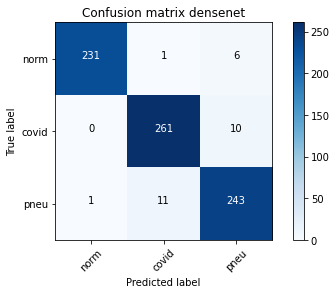

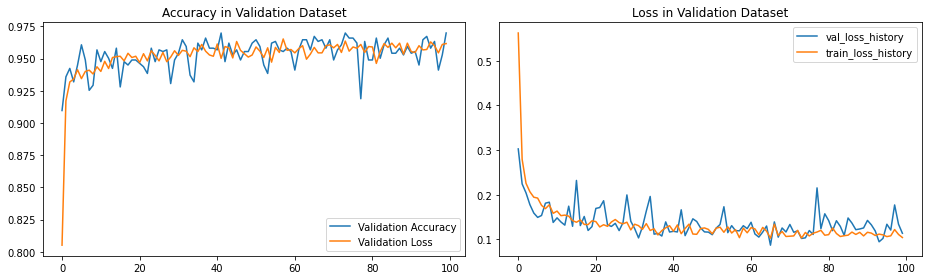


==== END ====
[[233   3   2]
 [  0 261  10]
 [  2   7 246]]

Sensitivity or recall total
0.9685863874345549

Sensitivity or recall per classes
[0.98 0.96 0.96]

Precision
[0.99 0.96 0.95]

F1 Score
[0.99 0.96 0.96]
Confusion matrix, without normalization

TESTE = 36/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.9775 Acc: 0.5601
val Loss: 0.7935 Acc: 0.7906
Epoch 1/99
----------
train Loss: 0.7124 Acc: 0.8330
val Loss: 0.6096 Acc: 0.8874
Epoch 2/99
----------
train Loss: 0.5817 Acc: 0.8863
val Loss: 0.5057 Acc: 0.9097
Epoch 3/99
----------
train Loss: 0.4961 Acc: 0.9027
val Loss: 0.4407 Acc: 0.9319
Epoch 4/99
----------
train Loss: 0.4443 Acc: 0.9060
val Loss: 0.3929 Acc: 0.9267
Epoch 5/99
----------
train Loss: 0.3989 Acc: 0.9243
val Loss: 0.3612 Acc:

train Loss: 0.1729 Acc: 0.9460
val Loss: 0.1507 Acc: 0.9490
Epoch 93/99
----------
train Loss: 0.1651 Acc: 0.9456
val Loss: 0.1577 Acc: 0.9437
Epoch 94/99
----------
train Loss: 0.1635 Acc: 0.9443
val Loss: 0.1432 Acc: 0.9555
Epoch 95/99
----------
train Loss: 0.1619 Acc: 0.9509
val Loss: 0.1457 Acc: 0.9568
Epoch 96/99
----------
train Loss: 0.1589 Acc: 0.9505
val Loss: 0.1557 Acc: 0.9450
Epoch 97/99
----------
train Loss: 0.1664 Acc: 0.9463
val Loss: 0.1435 Acc: 0.9450
Epoch 98/99
----------
train Loss: 0.1528 Acc: 0.9538
val Loss: 0.1620 Acc: 0.9476
Epoch 99/99
----------
train Loss: 0.1634 Acc: 0.9466
val Loss: 0.1353 Acc: 0.9620

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 30m 10s
Best val Acc: 0.962042
##############################


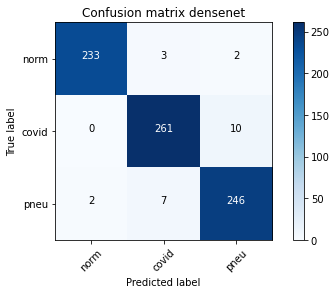

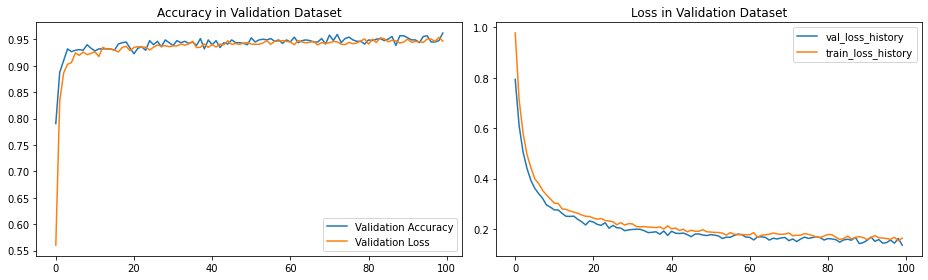


==== END ====
[[234   2   2]
 [  0 257  14]
 [  2  19 234]]

Sensitivity or recall total
0.9489528795811518

Sensitivity or recall per classes
[0.98 0.95 0.92]

Precision
[0.99 0.92 0.94]

F1 Score
[0.99 0.94 0.93]
Confusion matrix, without normalization

TESTE = 37/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.9367 Acc: 0.6236
val Loss: 0.7971 Acc: 0.8024
Epoch 1/99
----------
train Loss: 0.7277 Acc: 0.8271
val Loss: 0.6335 Acc: 0.8809
Epoch 2/99
----------
train Loss: 0.5908 Acc: 0.8801
val Loss: 0.5311 Acc: 0.9084
Epoch 3/99
----------
train Loss: 0.5078 Acc: 0.8926
val Loss: 0.4510 Acc: 0.9084
Epoch 4/99
----------
train Loss: 0.4496 Acc: 0.9083
val Loss: 0.4025 Acc: 0.9097
Epoch 5/99
----------
train Loss: 0.4026 Acc: 0.9171
val Loss: 0.3712 Acc:

train Loss: 0.1402 Acc: 0.9522
val Loss: 0.1348 Acc: 0.9529
Epoch 93/99
----------
train Loss: 0.1418 Acc: 0.9532
val Loss: 0.1371 Acc: 0.9568
Epoch 94/99
----------
train Loss: 0.1315 Acc: 0.9558
val Loss: 0.1314 Acc: 0.9594
Epoch 95/99
----------
train Loss: 0.1437 Acc: 0.9528
val Loss: 0.1286 Acc: 0.9594
Epoch 96/99
----------
train Loss: 0.1436 Acc: 0.9492
val Loss: 0.1361 Acc: 0.9503
Epoch 97/99
----------
train Loss: 0.1399 Acc: 0.9535
val Loss: 0.1235 Acc: 0.9634
Epoch 98/99
----------
train Loss: 0.1370 Acc: 0.9558
val Loss: 0.1358 Acc: 0.9476
Epoch 99/99
----------
train Loss: 0.1429 Acc: 0.9505
val Loss: 0.1386 Acc: 0.9490

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 30m 11s
Best val Acc: 0.963351
##############################


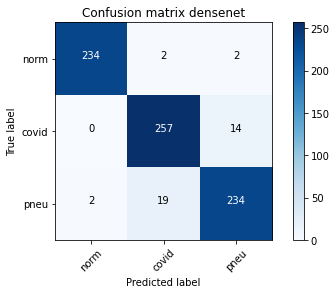

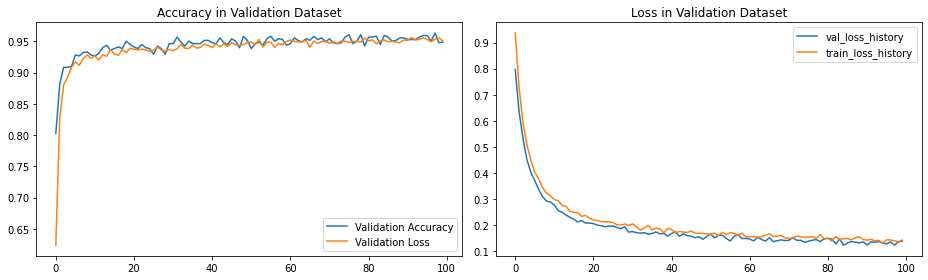


==== END ====
[[234   2   2]
 [  1 259  11]
 [  3  10 242]]

Sensitivity or recall total
0.9620418848167539

Sensitivity or recall per classes
[0.98 0.96 0.95]

Precision
[0.98 0.96 0.95]

F1 Score
[0.98 0.96 0.95]
Confusion matrix, without normalization

TESTE = 38/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.7711 Acc: 0.7701
val Loss: 0.6336 Acc: 0.8678
Epoch 1/99
----------
train Loss: 0.5736 Acc: 0.8785
val Loss: 0.4943 Acc: 0.9058
Epoch 2/99
----------
train Loss: 0.4856 Acc: 0.8994
val Loss: 0.4366 Acc: 0.9084
Epoch 3/99
----------
train Loss: 0.4293 Acc: 0.9047
val Loss: 0.3855 Acc: 0.9188
Epoch 4/99
----------
train Loss: 0.3873 Acc: 0.9106
val Loss: 0.3427 Acc: 0.9215
Epoch 5/99
----------
train Loss: 0.3518 Acc: 0.9230
val Loss: 0.3164 Acc:

train Loss: 0.1425 Acc: 0.9509
val Loss: 0.1364 Acc: 0.9476
Epoch 93/99
----------
train Loss: 0.1484 Acc: 0.9446
val Loss: 0.1331 Acc: 0.9568
Epoch 94/99
----------
train Loss: 0.1371 Acc: 0.9545
val Loss: 0.1191 Acc: 0.9542
Epoch 95/99
----------
train Loss: 0.1439 Acc: 0.9489
val Loss: 0.1333 Acc: 0.9529
Epoch 96/99
----------
train Loss: 0.1348 Acc: 0.9571
val Loss: 0.1323 Acc: 0.9607
Epoch 97/99
----------
train Loss: 0.1466 Acc: 0.9528
val Loss: 0.1215 Acc: 0.9555
Epoch 98/99
----------
train Loss: 0.1406 Acc: 0.9541
val Loss: 0.1357 Acc: 0.9516
Epoch 99/99
----------
train Loss: 0.1368 Acc: 0.9545
val Loss: 0.1263 Acc: 0.9594

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 8
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 30m 10s
Best val Acc: 0.964660
##############################


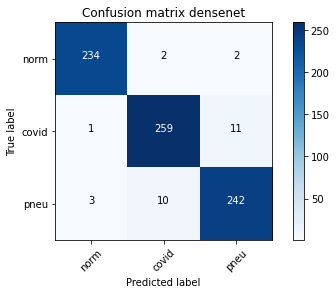

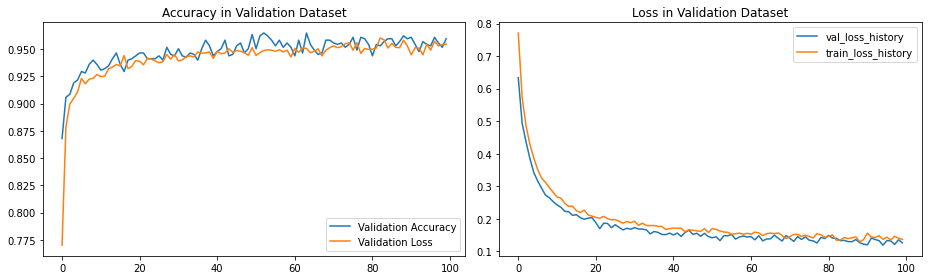


==== END ====
[[234   2   2]
 [  1 257  13]
 [  6  13 236]]

Sensitivity or recall total
0.9515706806282722

Sensitivity or recall per classes
[0.98 0.95 0.93]

Precision
[0.97 0.94 0.94]

F1 Score
[0.98 0.95 0.93]
Confusion matrix, without normalization

TESTE = 39/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.9839 Acc: 0.5300
val Loss: 0.8171 Acc: 0.7487
Epoch 1/99
----------
train Loss: 0.7328 Acc: 0.8113
val Loss: 0.6310 Acc: 0.8757
Epoch 2/99
----------
train Loss: 0.5896 Acc: 0.8723
val Loss: 0.5238 Acc: 0.8979
Epoch 3/99
----------
train Loss: 0.5122 Acc: 0.8837
val Loss: 0.4499 Acc: 0.9071
Epoch 4/99
----------
train Loss: 0.4535 Acc: 0.8962
val Loss: 0.4159 Acc: 0.9110
Epoch 5/99
----------
train Loss: 0.4116 Acc: 0.9184
val Loss: 0.3803 Acc

train Loss: 0.1667 Acc: 0.9440
val Loss: 0.1670 Acc: 0.9424
Epoch 93/99
----------
train Loss: 0.1582 Acc: 0.9473
val Loss: 0.1358 Acc: 0.9594
Epoch 94/99
----------
train Loss: 0.1644 Acc: 0.9496
val Loss: 0.1583 Acc: 0.9450
Epoch 95/99
----------
train Loss: 0.1677 Acc: 0.9482
val Loss: 0.1470 Acc: 0.9516
Epoch 96/99
----------
train Loss: 0.1686 Acc: 0.9437
val Loss: 0.1448 Acc: 0.9490
Epoch 97/99
----------
train Loss: 0.1717 Acc: 0.9433
val Loss: 0.1589 Acc: 0.9424
Epoch 98/99
----------
train Loss: 0.1559 Acc: 0.9486
val Loss: 0.1587 Acc: 0.9490
Epoch 99/99
----------
train Loss: 0.1672 Acc: 0.9469
val Loss: 0.1591 Acc: 0.9450

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 30m 6s
Best val Acc: 0.959424
##############################


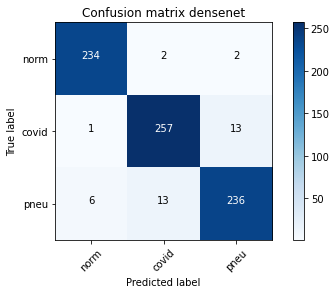

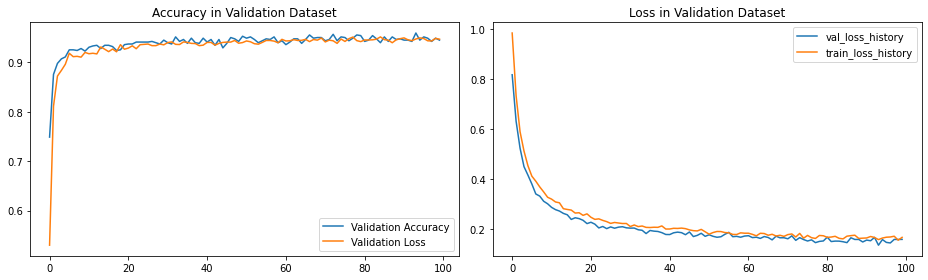


==== END ====
[[233   2   3]
 [  1 259  11]
 [  3  17 235]]

Sensitivity or recall total
0.9515706806282722

Sensitivity or recall per classes
[0.98 0.96 0.92]

Precision
[0.98 0.93 0.94]

F1 Score
[0.98 0.94 0.93]
Confusion matrix, without normalization

TESTE = 40/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.9471 Acc: 0.5971
val Loss: 0.8039 Acc: 0.7919
Epoch 1/99
----------
train Loss: 0.7270 Acc: 0.8212
val Loss: 0.6386 Acc: 0.8770
Epoch 2/99
----------
train Loss: 0.5957 Acc: 0.8719
val Loss: 0.5353 Acc: 0.8927
Epoch 3/99
----------
train Loss: 0.5134 Acc: 0.8913
val Loss: 0.4546 Acc: 0.9084
Epoch 4/99
----------
train Loss: 0.4489 Acc: 0.9073
val Loss: 0.4021 Acc: 0.9136
Epoch 5/99
----------
train Loss: 0.4090 Acc: 0.9171
val Loss: 0.3683 Acc

train Loss: 0.1398 Acc: 0.9541
val Loss: 0.1322 Acc: 0.9607
Epoch 93/99
----------
train Loss: 0.1380 Acc: 0.9568
val Loss: 0.1365 Acc: 0.9516
Epoch 94/99
----------
train Loss: 0.1470 Acc: 0.9482
val Loss: 0.1395 Acc: 0.9463
Epoch 95/99
----------
train Loss: 0.1370 Acc: 0.9564
val Loss: 0.1273 Acc: 0.9568
Epoch 96/99
----------
train Loss: 0.1332 Acc: 0.9522
val Loss: 0.1430 Acc: 0.9516
Epoch 97/99
----------
train Loss: 0.1394 Acc: 0.9532
val Loss: 0.1379 Acc: 0.9529
Epoch 98/99
----------
train Loss: 0.1495 Acc: 0.9486
val Loss: 0.1301 Acc: 0.9542
Epoch 99/99
----------
train Loss: 0.1438 Acc: 0.9476
val Loss: 0.1355 Acc: 0.9568

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 30m 8s
Best val Acc: 0.964660
##############################


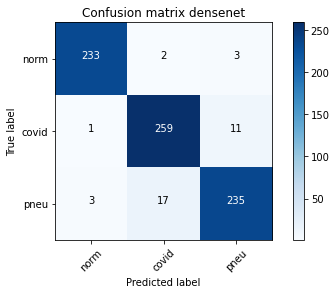

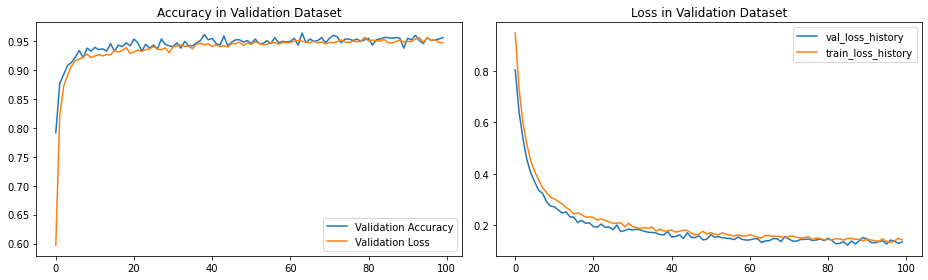


==== END ====
[[234   2   2]
 [  1 260  10]
 [  2  16 237]]

Sensitivity or recall total
0.9568062827225131

Sensitivity or recall per classes
[0.98 0.96 0.93]

Precision
[0.99 0.94 0.95]

F1 Score
[0.99 0.95 0.94]
Confusion matrix, without normalization

TESTE = 41/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.7986 Acc: 0.7530
val Loss: 0.6310 Acc: 0.8822
Epoch 1/99
----------
train Loss: 0.5948 Acc: 0.8729
val Loss: 0.5138 Acc: 0.9162
Epoch 2/99
----------
train Loss: 0.4979 Acc: 0.8994
val Loss: 0.4542 Acc: 0.9084
Epoch 3/99
----------
train Loss: 0.4322 Acc: 0.9116
val Loss: 0.3865 Acc: 0.9267
Epoch 4/99
----------
train Loss: 0.3911 Acc: 0.9194
val Loss: 0.3528 Acc: 0.9202
Epoch 5/99
----------
train Loss: 0.3550 Acc: 0.9220
val Loss: 0.3234 Acc

train Loss: 0.1478 Acc: 0.9505
val Loss: 0.1353 Acc: 0.9555
Epoch 93/99
----------
train Loss: 0.1322 Acc: 0.9574
val Loss: 0.1420 Acc: 0.9450
Epoch 94/99
----------
train Loss: 0.1405 Acc: 0.9532
val Loss: 0.1374 Acc: 0.9529
Epoch 95/99
----------
train Loss: 0.1368 Acc: 0.9568
val Loss: 0.1266 Acc: 0.9568
Epoch 96/99
----------
train Loss: 0.1369 Acc: 0.9551
val Loss: 0.1358 Acc: 0.9463
Epoch 97/99
----------
train Loss: 0.1340 Acc: 0.9522
val Loss: 0.1302 Acc: 0.9542
Epoch 98/99
----------
train Loss: 0.1359 Acc: 0.9541
val Loss: 0.1428 Acc: 0.9555
Epoch 99/99
----------
train Loss: 0.1423 Acc: 0.9505
val Loss: 0.1274 Acc: 0.9620

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 30m 7s
Best val Acc: 0.964660
##############################


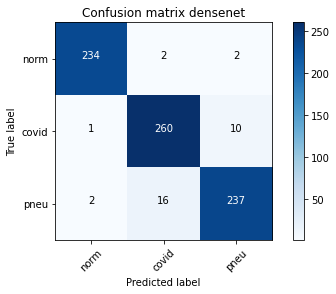

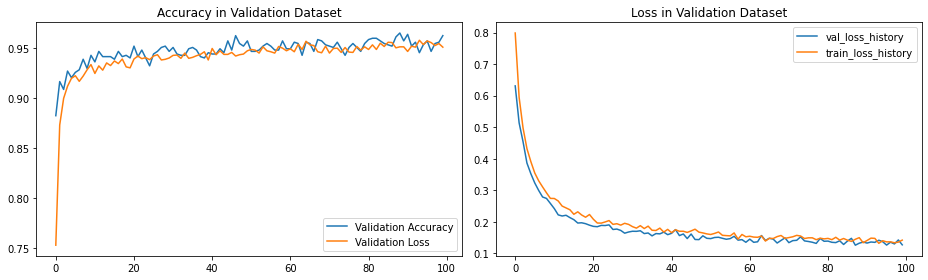


==== END ====
[[235   2   1]
 [  1 258  12]
 [  4  16 235]]

Sensitivity or recall total
0.9528795811518325

Sensitivity or recall per classes
[0.99 0.95 0.92]

Precision
[0.98 0.93 0.95]

F1 Score
[0.98 0.94 0.93]
Confusion matrix, without normalization

TESTE = 42/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.9447 Acc: 0.5827
val Loss: 0.7844 Acc: 0.7853
Epoch 1/99
----------
train Loss: 0.6994 Acc: 0.8293
val Loss: 0.6139 Acc: 0.8560
Epoch 2/99
----------
train Loss: 0.5790 Acc: 0.8726
val Loss: 0.5196 Acc: 0.8848
Epoch 3/99
----------
train Loss: 0.5029 Acc: 0.8922
val Loss: 0.4602 Acc: 0.8914
Epoch 4/99
----------
train Loss: 0.4473 Acc: 0.9027
val Loss: 0.3959 Acc: 0.9097
Epoch 5/99
----------
train Loss: 0.4077 Acc: 0.9148
val Loss: 0.3740 Acc

train Loss: 0.1663 Acc: 0.9450
val Loss: 0.1455 Acc: 0.9490
Epoch 93/99
----------
train Loss: 0.1658 Acc: 0.9469
val Loss: 0.1553 Acc: 0.9450
Epoch 94/99
----------
train Loss: 0.1652 Acc: 0.9466
val Loss: 0.1533 Acc: 0.9568
Epoch 95/99
----------
train Loss: 0.1647 Acc: 0.9482
val Loss: 0.1485 Acc: 0.9450
Epoch 96/99
----------
train Loss: 0.1700 Acc: 0.9479
val Loss: 0.1573 Acc: 0.9542
Epoch 97/99
----------
train Loss: 0.1634 Acc: 0.9446
val Loss: 0.1467 Acc: 0.9542
Epoch 98/99
----------
train Loss: 0.1659 Acc: 0.9476
val Loss: 0.1525 Acc: 0.9542
Epoch 99/99
----------
train Loss: 0.1693 Acc: 0.9460
val Loss: 0.1533 Acc: 0.9490

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 30m 10s
Best val Acc: 0.958115
##############################


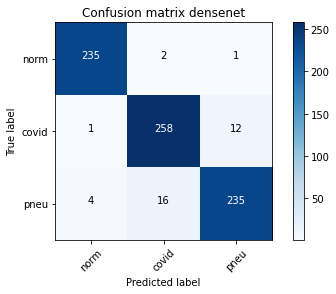

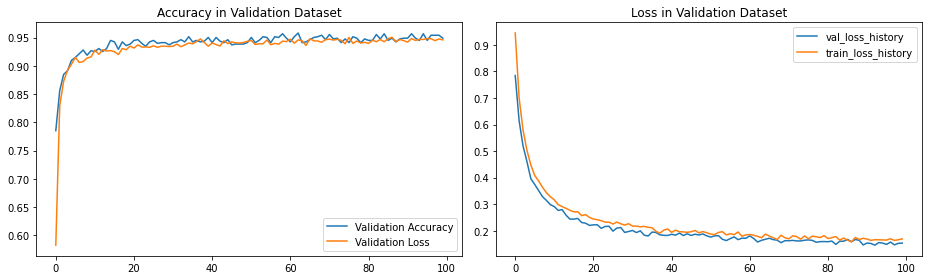


==== END ====
[[233   2   3]
 [  2 258  11]
 [  4  22 229]]

Sensitivity or recall total
0.9424083769633508

Sensitivity or recall per classes
[0.98 0.95 0.9 ]

Precision
[0.97 0.91 0.94]

F1 Score
[0.98 0.93 0.92]
Confusion matrix, without normalization

TESTE = 43/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.9769 Acc: 0.5549
val Loss: 0.8239 Acc: 0.7592
Epoch 1/99
----------
train Loss: 0.7494 Acc: 0.7933
val Loss: 0.6528 Acc: 0.8691
Epoch 2/99
----------
train Loss: 0.6116 Acc: 0.8677
val Loss: 0.5329 Acc: 0.9058
Epoch 3/99
----------
train Loss: 0.5210 Acc: 0.8909
val Loss: 0.4726 Acc: 0.9071
Epoch 4/99
----------
train Loss: 0.4590 Acc: 0.9073
val Loss: 0.4022 Acc: 0.9254
Epoch 5/99
----------
train Loss: 0.4148 Acc: 0.9086
val Loss: 0.3751 Acc

train Loss: 0.1369 Acc: 0.9558
val Loss: 0.1389 Acc: 0.9568
Epoch 93/99
----------
train Loss: 0.1407 Acc: 0.9522
val Loss: 0.1267 Acc: 0.9555
Epoch 94/99
----------
train Loss: 0.1391 Acc: 0.9548
val Loss: 0.1365 Acc: 0.9542
Epoch 95/99
----------
train Loss: 0.1456 Acc: 0.9548
val Loss: 0.1418 Acc: 0.9568
Epoch 96/99
----------
train Loss: 0.1423 Acc: 0.9522
val Loss: 0.1220 Acc: 0.9660
Epoch 97/99
----------
train Loss: 0.1365 Acc: 0.9541
val Loss: 0.1322 Acc: 0.9503
Epoch 98/99
----------
train Loss: 0.1422 Acc: 0.9525
val Loss: 0.1332 Acc: 0.9529
Epoch 99/99
----------
train Loss: 0.1448 Acc: 0.9532
val Loss: 0.1298 Acc: 0.9594

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 30m 5s
Best val Acc: 0.965969
##############################


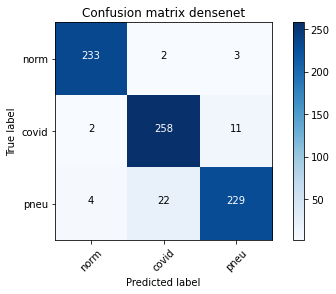

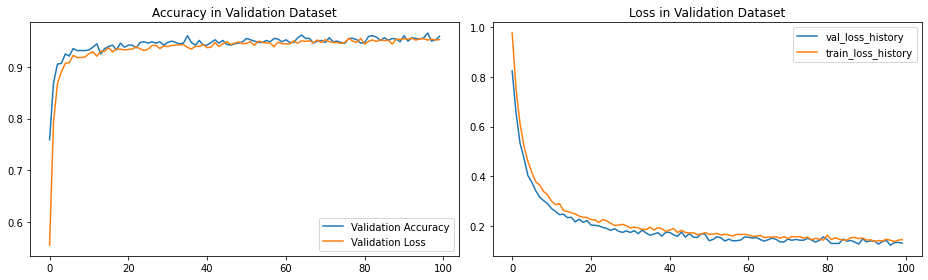


==== END ====
[[234   2   2]
 [  0 262   9]
 [  1  18 236]]

Sensitivity or recall total
0.9581151832460733

Sensitivity or recall per classes
[0.98 0.97 0.93]

Precision
[1.   0.93 0.96]

F1 Score
[0.99 0.95 0.94]
Confusion matrix, without normalization

TESTE = 44/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.7837 Acc: 0.7494
val Loss: 0.6336 Acc: 0.8770
Epoch 1/99
----------
train Loss: 0.5844 Acc: 0.8867
val Loss: 0.5032 Acc: 0.9175
Epoch 2/99
----------
train Loss: 0.4909 Acc: 0.9040
val Loss: 0.4455 Acc: 0.9306
Epoch 3/99
----------
train Loss: 0.4346 Acc: 0.9063
val Loss: 0.3795 Acc: 0.9267
Epoch 4/99
----------
train Loss: 0.3785 Acc: 0.9237
val Loss: 0.3456 Acc: 0.9241
Epoch 5/99
----------
train Loss: 0.3574 Acc: 0.9152
val Loss: 0.3239 Acc

train Loss: 0.1348 Acc: 0.9525
val Loss: 0.1241 Acc: 0.9607
Epoch 93/99
----------
train Loss: 0.1388 Acc: 0.9535
val Loss: 0.1229 Acc: 0.9607
Epoch 94/99
----------
train Loss: 0.1411 Acc: 0.9496
val Loss: 0.1265 Acc: 0.9555
Epoch 95/99
----------
train Loss: 0.1409 Acc: 0.9515
val Loss: 0.1304 Acc: 0.9581
Epoch 96/99
----------
train Loss: 0.1325 Acc: 0.9551
val Loss: 0.1307 Acc: 0.9490
Epoch 97/99
----------
train Loss: 0.1421 Acc: 0.9515
val Loss: 0.1364 Acc: 0.9542
Epoch 98/99
----------
train Loss: 0.1260 Acc: 0.9587
val Loss: 0.1419 Acc: 0.9555
Epoch 99/99
----------
train Loss: 0.1357 Acc: 0.9545
val Loss: 0.1320 Acc: 0.9581

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 32
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 29m 60s
Best val Acc: 0.963351
##############################


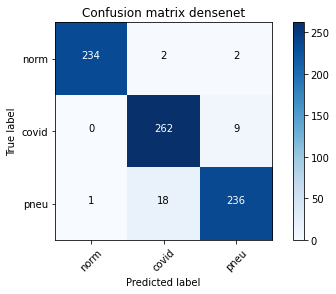

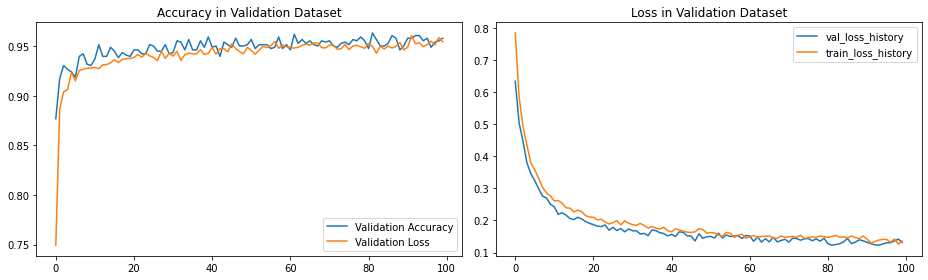


==== END ====
[[234   1   3]
 [  0 259  12]
 [  3  14 238]]

Sensitivity or recall total
0.9568062827225131

Sensitivity or recall per classes
[0.98 0.96 0.93]

Precision
[0.99 0.95 0.94]

F1 Score
[0.99 0.95 0.94]
Confusion matrix, without normalization

TESTE = 45/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.1784 Acc: 0.3095
val Loss: 1.1472 Acc: 0.3024
Epoch 1/99
----------
train Loss: 1.1024 Acc: 0.3413
val Loss: 1.0838 Acc: 0.3717
Epoch 2/99
----------
train Loss: 1.0584 Acc: 0.4081
val Loss: 1.0431 Acc: 0.4450
Epoch 3/99
----------
train Loss: 1.0124 Acc: 0.4894
val Loss: 1.0013 Acc: 0.5105
Epoch 4/99
----------
train Loss: 0.9821 Acc: 0.5493
val Loss: 0.9633 Acc: 0.5694
Epoch 5/99
----------
train Loss: 0.9423 Acc: 0.6060
val Loss: 0.9302 Acc: 

train Loss: 0.3257 Acc: 0.9279
val Loss: 0.3067 Acc: 0.9267
Epoch 93/99
----------
train Loss: 0.3268 Acc: 0.9256
val Loss: 0.3023 Acc: 0.9306
Epoch 94/99
----------
train Loss: 0.3252 Acc: 0.9220
val Loss: 0.3068 Acc: 0.9267
Epoch 95/99
----------
train Loss: 0.3181 Acc: 0.9279
val Loss: 0.2910 Acc: 0.9437
Epoch 96/99
----------
train Loss: 0.3187 Acc: 0.9276
val Loss: 0.3070 Acc: 0.9280
Epoch 97/99
----------
train Loss: 0.3177 Acc: 0.9266
val Loss: 0.2861 Acc: 0.9411
Epoch 98/99
----------
train Loss: 0.3169 Acc: 0.9247
val Loss: 0.2932 Acc: 0.9319
Epoch 99/99
----------
train Loss: 0.3067 Acc: 0.9315
val Loss: 0.2870 Acc: 0.9346

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 30m 2s
Best val Acc: 0.943717
##############################


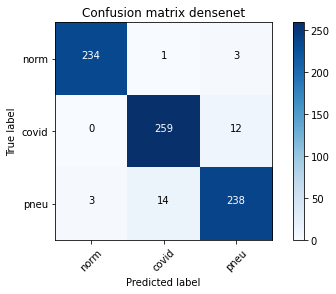

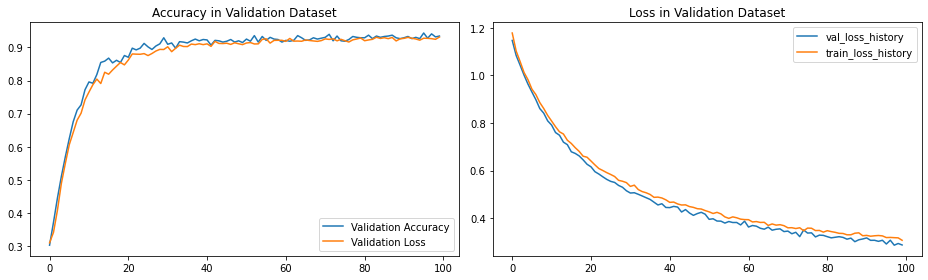


==== END ====
[[229   3   6]
 [  1 250  20]
 [  5  18 232]]

Sensitivity or recall total
0.930628272251309

Sensitivity or recall per classes
[0.96 0.92 0.91]

Precision
[0.97 0.92 0.9 ]

F1 Score
[0.97 0.92 0.9 ]
Confusion matrix, without normalization

TESTE = 46/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0969 Acc: 0.3501
val Loss: 1.0794 Acc: 0.3783
Epoch 1/99
----------
train Loss: 1.0528 Acc: 0.4121
val Loss: 1.0416 Acc: 0.4149
Epoch 2/99
----------
train Loss: 1.0233 Acc: 0.4645
val Loss: 0.9976 Acc: 0.5065
Epoch 3/99
----------
train Loss: 0.9966 Acc: 0.5159
val Loss: 0.9606 Acc: 0.5668
Epoch 4/99
----------
train Loss: 0.9612 Acc: 0.5889
val Loss: 0.9392 Acc: 0.6401
Epoch 5/99
----------
train Loss: 0.9338 Acc: 0.6351
val Loss: 0.9175 Acc: 0

train Loss: 0.2925 Acc: 0.9315
val Loss: 0.2722 Acc: 0.9332
Epoch 93/99
----------
train Loss: 0.2991 Acc: 0.9263
val Loss: 0.2748 Acc: 0.9372
Epoch 94/99
----------
train Loss: 0.2931 Acc: 0.9338
val Loss: 0.2777 Acc: 0.9332
Epoch 95/99
----------
train Loss: 0.2992 Acc: 0.9253
val Loss: 0.2682 Acc: 0.9372
Epoch 96/99
----------
train Loss: 0.2954 Acc: 0.9204
val Loss: 0.2726 Acc: 0.9267
Epoch 97/99
----------
train Loss: 0.2966 Acc: 0.9237
val Loss: 0.2697 Acc: 0.9267
Epoch 98/99
----------
train Loss: 0.2949 Acc: 0.9243
val Loss: 0.2668 Acc: 0.9411
Epoch 99/99
----------
train Loss: 0.2856 Acc: 0.9283
val Loss: 0.2760 Acc: 0.9280

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 29m 57s
Best val Acc: 0.941099
##############################


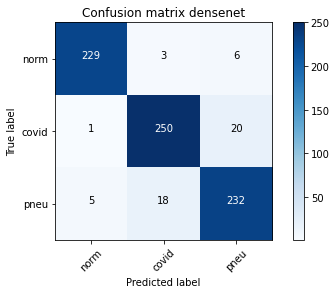

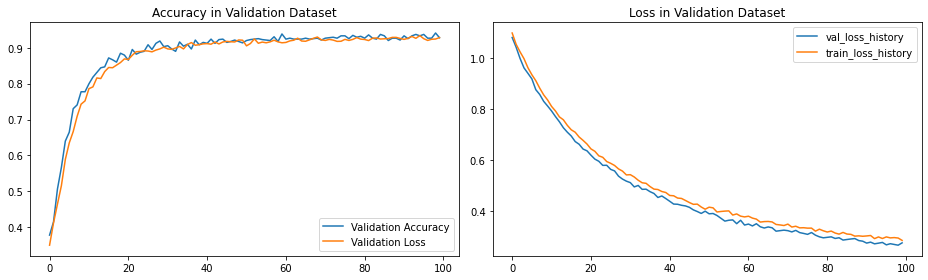


==== END ====
[[232   3   3]
 [  5 253  13]
 [  6  24 225]]

Sensitivity or recall total
0.9293193717277487

Sensitivity or recall per classes
[0.97 0.93 0.88]

Precision
[0.95 0.9  0.93]

F1 Score
[0.96 0.92 0.91]
Confusion matrix, without normalization

TESTE = 47/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0950 Acc: 0.3711
val Loss: 1.0777 Acc: 0.3940
Epoch 1/99
----------
train Loss: 1.0364 Acc: 0.4782
val Loss: 1.0267 Acc: 0.4895
Epoch 2/99
----------
train Loss: 1.0057 Acc: 0.5231
val Loss: 0.9885 Acc: 0.5602
Epoch 3/99
----------
train Loss: 0.9768 Acc: 0.5657
val Loss: 0.9569 Acc: 0.5929
Epoch 4/99
----------
train Loss: 0.9419 Acc: 0.6315
val Loss: 0.9310 Acc: 0.6217
Epoch 5/99
----------
train Loss: 0.9094 Acc: 0.6659
val Loss: 0.8930 Acc: 

train Loss: 0.2933 Acc: 0.9204
val Loss: 0.2601 Acc: 0.9280
Epoch 93/99
----------
train Loss: 0.2897 Acc: 0.9253
val Loss: 0.2733 Acc: 0.9332
Epoch 94/99
----------
train Loss: 0.2803 Acc: 0.9299
val Loss: 0.2629 Acc: 0.9319
Epoch 95/99
----------
train Loss: 0.2851 Acc: 0.9296
val Loss: 0.2621 Acc: 0.9267
Epoch 96/99
----------
train Loss: 0.2809 Acc: 0.9286
val Loss: 0.2640 Acc: 0.9385
Epoch 97/99
----------
train Loss: 0.2832 Acc: 0.9312
val Loss: 0.2603 Acc: 0.9346
Epoch 98/99
----------
train Loss: 0.2785 Acc: 0.9270
val Loss: 0.2674 Acc: 0.9306
Epoch 99/99
----------
train Loss: 0.2848 Acc: 0.9188
val Loss: 0.2568 Acc: 0.9424

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 8
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 29m 58s
Best val Acc: 0.942408
##############################


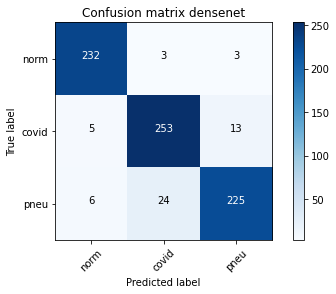

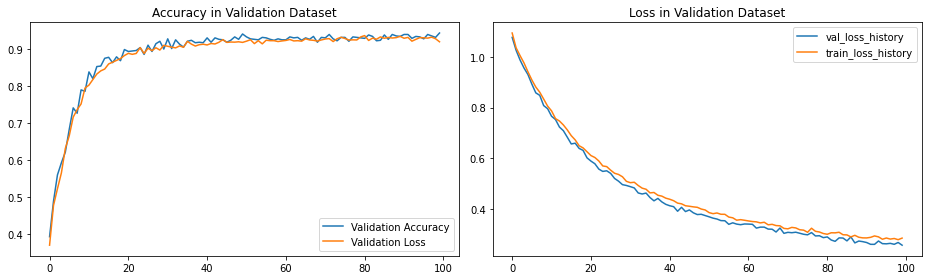


==== END ====
[[231   2   5]
 [  2 258  11]
 [  2  23 230]]

Sensitivity or recall total
0.9410994764397905

Sensitivity or recall per classes
[0.97 0.95 0.9 ]

Precision
[0.98 0.91 0.93]

F1 Score
[0.98 0.93 0.92]
Confusion matrix, without normalization

TESTE = 48/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.1353 Acc: 0.3472
val Loss: 1.0970 Acc: 0.3626
Epoch 1/99
----------
train Loss: 1.0741 Acc: 0.3875
val Loss: 1.0392 Acc: 0.4555
Epoch 2/99
----------
train Loss: 1.0261 Acc: 0.4785
val Loss: 1.0072 Acc: 0.5092
Epoch 3/99
----------
train Loss: 0.9903 Acc: 0.5313
val Loss: 0.9585 Acc: 0.5877
Epoch 4/99
----------
train Loss: 0.9553 Acc: 0.5984
val Loss: 0.9262 Acc: 0.6518
Epoch 5/99
----------
train Loss: 0.9276 Acc: 0.6502
val Loss: 0.9019 Acc:

train Loss: 0.3316 Acc: 0.9230
val Loss: 0.3004 Acc: 0.9385
Epoch 93/99
----------
train Loss: 0.3303 Acc: 0.9184
val Loss: 0.3130 Acc: 0.9162
Epoch 94/99
----------
train Loss: 0.3302 Acc: 0.9148
val Loss: 0.3029 Acc: 0.9372
Epoch 95/99
----------
train Loss: 0.3206 Acc: 0.9253
val Loss: 0.2890 Acc: 0.9306
Epoch 96/99
----------
train Loss: 0.3299 Acc: 0.9155
val Loss: 0.3069 Acc: 0.9241
Epoch 97/99
----------
train Loss: 0.3219 Acc: 0.9234
val Loss: 0.2950 Acc: 0.9293
Epoch 98/99
----------
train Loss: 0.3210 Acc: 0.9247
val Loss: 0.2991 Acc: 0.9241
Epoch 99/99
----------
train Loss: 0.3250 Acc: 0.9207
val Loss: 0.2975 Acc: 0.9372

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 30m 5s
Best val Acc: 0.942408
##############################


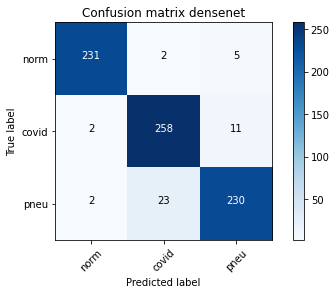

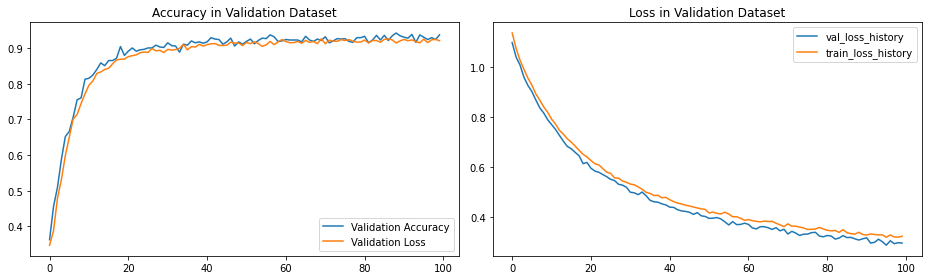


==== END ====
[[232   2   4]
 [  4 250  17]
 [  8  22 225]]

Sensitivity or recall total
0.925392670157068

Sensitivity or recall per classes
[0.97 0.92 0.88]

Precision
[0.95 0.91 0.91]

F1 Score
[0.96 0.92 0.9 ]
Confusion matrix, without normalization

TESTE = 49/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.1279 Acc: 0.3639
val Loss: 1.1136 Acc: 0.3796
Epoch 1/99
----------
train Loss: 1.0821 Acc: 0.4137
val Loss: 1.0706 Acc: 0.4228
Epoch 2/99
----------
train Loss: 1.0488 Acc: 0.4720
val Loss: 1.0430 Acc: 0.4712
Epoch 3/99
----------
train Loss: 1.0176 Acc: 0.5090
val Loss: 1.0048 Acc: 0.5209
Epoch 4/99
----------
train Loss: 0.9915 Acc: 0.5526
val Loss: 0.9629 Acc: 0.5864
Epoch 5/99
----------
train Loss: 0.9584 Acc: 0.5906
val Loss: 0.9520 Acc: 

train Loss: 0.3044 Acc: 0.9273
val Loss: 0.2852 Acc: 0.9346
Epoch 93/99
----------
train Loss: 0.2991 Acc: 0.9263
val Loss: 0.2795 Acc: 0.9346
Epoch 94/99
----------
train Loss: 0.3044 Acc: 0.9250
val Loss: 0.2840 Acc: 0.9267
Epoch 95/99
----------
train Loss: 0.2960 Acc: 0.9253
val Loss: 0.2775 Acc: 0.9306
Epoch 96/99
----------
train Loss: 0.2943 Acc: 0.9296
val Loss: 0.2852 Acc: 0.9332
Epoch 97/99
----------
train Loss: 0.3041 Acc: 0.9234
val Loss: 0.2687 Acc: 0.9306
Epoch 98/99
----------
train Loss: 0.2875 Acc: 0.9312
val Loss: 0.2748 Acc: 0.9202
Epoch 99/99
----------
train Loss: 0.2939 Acc: 0.9240
val Loss: 0.2688 Acc: 0.9385

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 30m 0s
Best val Acc: 0.939791
##############################


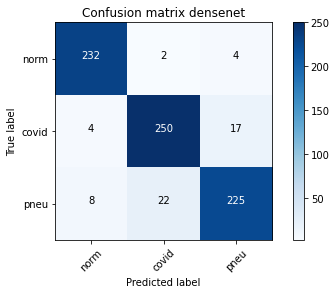

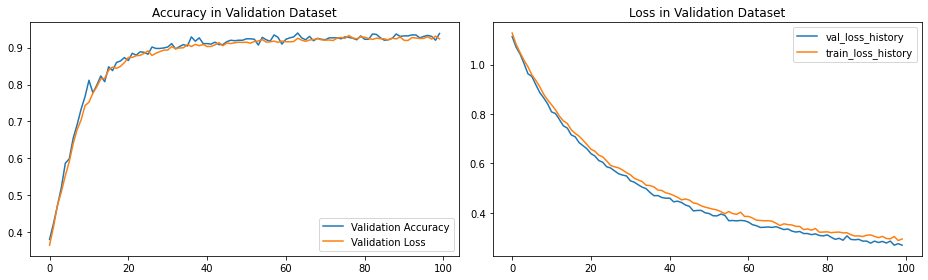


==== END ====
[[227   2   9]
 [  2 252  17]
 [  9  25 221]]

Sensitivity or recall total
0.9162303664921466

Sensitivity or recall per classes
[0.95 0.93 0.87]

Precision
[0.95 0.9  0.89]

F1 Score
[0.95 0.92 0.88]
Confusion matrix, without normalization

TESTE = 50/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.1438 Acc: 0.3043
val Loss: 1.1067 Acc: 0.3573
Epoch 1/99
----------
train Loss: 1.0721 Acc: 0.4193
val Loss: 1.0584 Acc: 0.4699
Epoch 2/99
----------
train Loss: 1.0343 Acc: 0.4890
val Loss: 1.0147 Acc: 0.5262
Epoch 3/99
----------
train Loss: 1.0016 Acc: 0.5454
val Loss: 0.9900 Acc: 0.5550
Epoch 4/99
----------
train Loss: 0.9730 Acc: 0.5716
val Loss: 0.9556 Acc: 0.5916
Epoch 5/99
----------
train Loss: 0.9442 Acc: 0.6273
val Loss: 0.9257 Acc:

train Loss: 0.2951 Acc: 0.9247
val Loss: 0.2768 Acc: 0.9280
Epoch 93/99
----------
train Loss: 0.2930 Acc: 0.9296
val Loss: 0.2703 Acc: 0.9280
Epoch 94/99
----------
train Loss: 0.2913 Acc: 0.9270
val Loss: 0.2682 Acc: 0.9280
Epoch 95/99
----------
train Loss: 0.2881 Acc: 0.9247
val Loss: 0.2656 Acc: 0.9280
Epoch 96/99
----------
train Loss: 0.2785 Acc: 0.9296
val Loss: 0.2627 Acc: 0.9372
Epoch 97/99
----------
train Loss: 0.2868 Acc: 0.9296
val Loss: 0.2633 Acc: 0.9398
Epoch 98/99
----------
train Loss: 0.2800 Acc: 0.9273
val Loss: 0.2661 Acc: 0.9306
Epoch 99/99
----------
train Loss: 0.2865 Acc: 0.9276
val Loss: 0.2623 Acc: 0.9385

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 16
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 30m 0s
Best val Acc: 0.939791
##############################


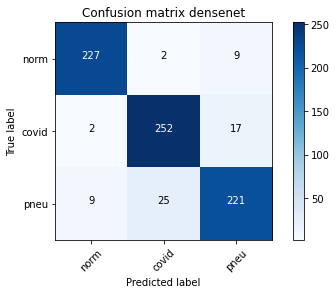

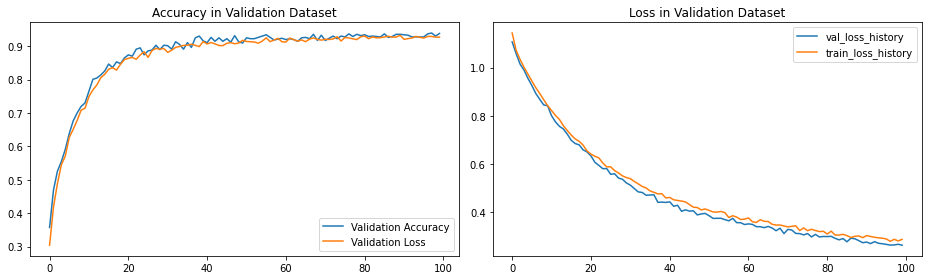


==== END ====
[[235   2   1]
 [  2 256  13]
 [  7  19 229]]

Sensitivity or recall total
0.9424083769633508

Sensitivity or recall per classes
[0.99 0.94 0.9 ]

Precision
[0.96 0.92 0.94]

F1 Score
[0.98 0.93 0.92]
Confusion matrix, without normalization

TESTE = 51/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0548 Acc: 0.4281
val Loss: 1.0073 Acc: 0.5471
Epoch 1/99
----------
train Loss: 1.0037 Acc: 0.5205
val Loss: 0.9833 Acc: 0.5694
Epoch 2/99
----------
train Loss: 0.9685 Acc: 0.5716
val Loss: 0.9403 Acc: 0.6387
Epoch 3/99
----------
train Loss: 0.9377 Acc: 0.6151
val Loss: 0.9109 Acc: 0.6688
Epoch 4/99
----------
train Loss: 0.9035 Acc: 0.6708
val Loss: 0.8762 Acc: 0.7107
Epoch 5/99
----------
train Loss: 0.8807 Acc: 0.6993
val Loss: 0.8409 Acc:

train Loss: 0.3237 Acc: 0.9207
val Loss: 0.3003 Acc: 0.9319
Epoch 93/99
----------
train Loss: 0.3202 Acc: 0.9260
val Loss: 0.2998 Acc: 0.9346
Epoch 94/99
----------
train Loss: 0.3312 Acc: 0.9184
val Loss: 0.3021 Acc: 0.9306
Epoch 95/99
----------
train Loss: 0.3229 Acc: 0.9217
val Loss: 0.2968 Acc: 0.9228
Epoch 96/99
----------
train Loss: 0.3230 Acc: 0.9230
val Loss: 0.2967 Acc: 0.9332
Epoch 97/99
----------
train Loss: 0.3114 Acc: 0.9260
val Loss: 0.2872 Acc: 0.9385
Epoch 98/99
----------
train Loss: 0.3249 Acc: 0.9178
val Loss: 0.2953 Acc: 0.9306
Epoch 99/99
----------
train Loss: 0.3134 Acc: 0.9263
val Loss: 0.2955 Acc: 0.9267

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> SGD
criteriun -> CrossEntropyLoss

Training complete in 30m 4s
Best val Acc: 0.939791
##############################


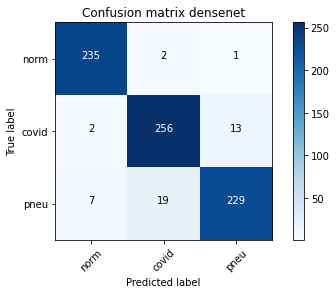

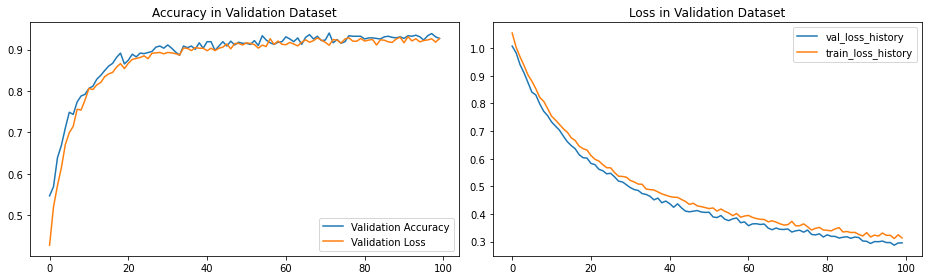


==== END ====
[[225   3  10]
 [  0 259  12]
 [  6  33 216]]

Sensitivity or recall total
0.9162303664921466

Sensitivity or recall per classes
[0.95 0.96 0.85]

Precision
[0.97 0.88 0.91]

F1 Score
[0.96 0.92 0.88]
Confusion matrix, without normalization

TESTE = 52/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.1270 Acc: 0.3194
val Loss: 1.0937 Acc: 0.3730
Epoch 1/99
----------
train Loss: 1.0802 Acc: 0.4045
val Loss: 1.0653 Acc: 0.4450
Epoch 2/99
----------
train Loss: 1.0492 Acc: 0.4605
val Loss: 1.0289 Acc: 0.4987
Epoch 3/99
----------
train Loss: 1.0164 Acc: 0.5090
val Loss: 0.9907 Acc: 0.5380
Epoch 4/99
----------
train Loss: 0.9844 Acc: 0.5542
val Loss: 0.9647 Acc: 0.5812
Epoch 5/99
----------
train Loss: 0.9577 Acc: 0.5938
val Loss: 0.9185 Acc:

train Loss: 0.2980 Acc: 0.9237
val Loss: 0.2748 Acc: 0.9254
Epoch 93/99
----------
train Loss: 0.3009 Acc: 0.9276
val Loss: 0.2742 Acc: 0.9319
Epoch 94/99
----------
train Loss: 0.2970 Acc: 0.9286
val Loss: 0.2736 Acc: 0.9372
Epoch 95/99
----------
train Loss: 0.2922 Acc: 0.9260
val Loss: 0.2786 Acc: 0.9280
Epoch 96/99
----------
train Loss: 0.2949 Acc: 0.9296
val Loss: 0.2741 Acc: 0.9398
Epoch 97/99
----------
train Loss: 0.2902 Acc: 0.9273
val Loss: 0.2714 Acc: 0.9424
Epoch 98/99
----------
train Loss: 0.2912 Acc: 0.9276
val Loss: 0.2670 Acc: 0.9267
Epoch 99/99
----------
train Loss: 0.2843 Acc: 0.9322
val Loss: 0.2638 Acc: 0.9319

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> ADAM
criteriun -> CrossEntropyLoss

Training complete in 30m 2s
Best val Acc: 0.943717
##############################


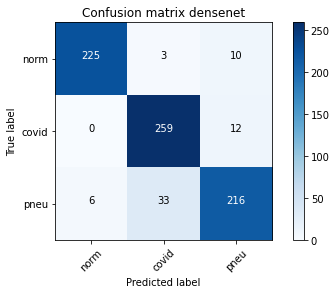

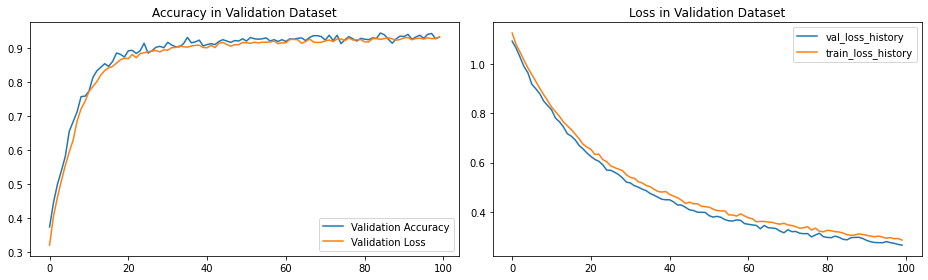


==== END ====
[[232   2   4]
 [  1 248  22]
 [  7  20 228]]

Sensitivity or recall total
0.9267015706806283

Sensitivity or recall per classes
[0.97 0.92 0.89]

Precision
[0.97 0.92 0.9 ]

F1 Score
[0.97 0.92 0.9 ]
Confusion matrix, without normalization

TESTE = 53/54

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 1.0506 Acc: 0.4415
val Loss: 1.0220 Acc: 0.4895
Epoch 1/99
----------
train Loss: 0.9968 Acc: 0.5110
val Loss: 0.9850 Acc: 0.5327
Epoch 2/99
----------
train Loss: 0.9724 Acc: 0.5500
val Loss: 0.9416 Acc: 0.5982
Epoch 3/99
----------
train Loss: 0.9441 Acc: 0.5870
val Loss: 0.9210 Acc: 0.6309
Epoch 4/99
----------
train Loss: 0.9129 Acc: 0.6276
val Loss: 0.8994 Acc: 0.6361
Epoch 5/99
----------
train Loss: 0.8880 Acc: 0.6630
val Loss: 0.8752 Acc:

train Loss: 0.2953 Acc: 0.9240
val Loss: 0.2668 Acc: 0.9306
Epoch 93/99
----------
train Loss: 0.2938 Acc: 0.9240
val Loss: 0.2731 Acc: 0.9162
Epoch 94/99
----------
train Loss: 0.2856 Acc: 0.9296
val Loss: 0.2743 Acc: 0.9306
Epoch 95/99
----------
train Loss: 0.2863 Acc: 0.9237
val Loss: 0.2561 Acc: 0.9385
Epoch 96/99
----------
train Loss: 0.2846 Acc: 0.9306
val Loss: 0.2707 Acc: 0.9332
Epoch 97/99
----------
train Loss: 0.2872 Acc: 0.9237
val Loss: 0.2654 Acc: 0.9319
Epoch 98/99
----------
train Loss: 0.2800 Acc: 0.9309
val Loss: 0.2631 Acc: 0.9346
Epoch 99/99
----------
train Loss: 0.2850 Acc: 0.9270
val Loss: 0.2596 Acc: 0.9385

##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 1e-05
batch size -> 32
optimizer -> RMSprop
criteriun -> CrossEntropyLoss

Training complete in 30m 11s
Best val Acc: 0.938482
##############################


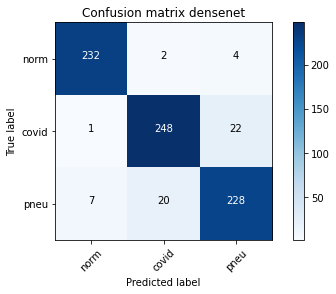

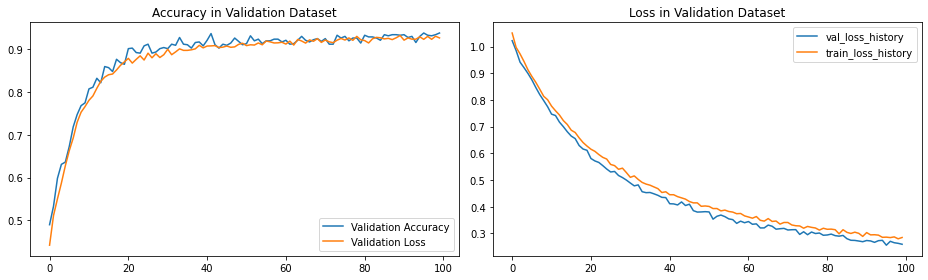


==== END ====
[[231   2   5]
 [  3 252  16]
 [  6  17 232]]

Sensitivity or recall total
0.9358638743455497

Sensitivity or recall per classes
[0.97 0.93 0.91]

Precision
[0.96 0.93 0.92]

F1 Score
[0.97 0.93 0.91]
Confusion matrix, without normalization

TESTE = 54/54


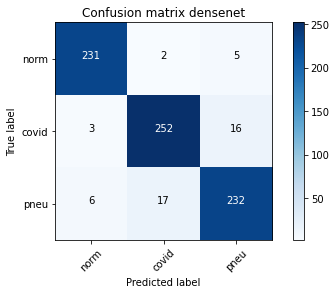

In [12]:
# Modelos ['squeezenet', 'densenet', 'resnet', 'alexnet', 'vgg', 'googlenet', 'shufflenet', 'mobilenet']
num_classes = 3

_models = ['squeezenet', 'densenet'] #, 'resnet', 'alexnet', 'vgg', 'googlenet', 'shufflenet', 'mobilenet']
lrs = [1e-3, 1e-4, 1e-5] #9+9+9 = 27 -> 27 testes por rede
_epoch = [100]
batch_sizes = [8, 16, 32] #9
opt = [1, 2, 3] #1 SGD - 2 ADAM - 3 RMSprop
crt = [1] # 1 CrossEntropyLoss - 2 BCELoss

count = 0
for _model in _models:
    for _epochs in _epoch:
        for _lrs in lrs:
            for _batch in batch_sizes:
                for _opt in opt:
                    for _crt in crt:
                                                    
                        print()
                        print('='*60)
                        print('==== INITIALIZING WITH PARAMETERS: ====')
                        print(f'model -> {_model}')
                        print(f'epochs -> {_epochs}')
                        print(f'lr -> {_lrs}')
                        print(f'batch size -> {_batch}')
                        print(f'optimizer -> {_opt}')
                        print(f'criteriun -> {_crt}')
                        print()

                        feature_extract = True

                        model_ft, input_size = initialize_model(_model, num_classes, 
                                                                feature_extract, use_pretrained=True)

                        
                        
                        # Send the model to GPU
                        model_ft = model_ft.to(device)

                        print('-'*20)
                        params_to_update = model_ft.parameters()
                        print("Params to learn:")
                        if feature_extract:
                            params_to_update = []
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    params_to_update.append(param)
                                    print("\t",name)

                        else:
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    print("\t",name)


                        print()
                        print('-'*20)
                        print()
                        print('== Epochs ==')

                        if _opt == 1:
                            optimizer_ft = optim.SGD(params_to_update, _lrs, momentum=0.9)
                            opt_name = 'SGD'

                        if _opt == 2:
                            optimizer_ft = optim.Adam(params_to_update, _lrs)
                            opt_name = 'ADAM'
                            
                        if _opt == 3:
                            optimizer_ft = optim.RMSprop(params_to_update, _lrs)
                            opt_name = 'RMSprop'


                        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)


                        if _crt == 1:
                            criterion = nn.CrossEntropyLoss()
                            crt_name = 'CrossEntropyLoss'
                            
                        if _crt == 2:
                            criterion = nn.BCELoss()
                            crt_name = 'BCELoss'


                        model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft,
                                                num_epochs=_epochs, model_name=_model, lr=_lrs,
                                                batch_size=_batch, opt_name=opt_name, crt_name=crt_name)
                        
                        

                        from sklearn.metrics import confusion_matrix

                        nb_classes = 3

                        # Initialize the prediction and label lists(tensors)
                        predlist=torch.zeros(0,dtype=torch.long, device='cpu')
                        lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

                        with torch.no_grad():
                            for i, (inputs, classes) in enumerate(dataloaders['val']):
                                inputs = inputs.to(device) #labels atuais
                                classes = classes.to(device) #classes
                                outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
                                _, preds = torch.max(outputs, 1) #pega o maior valor das predições

                                # Append batch prediction results
                                predlist=torch.cat([predlist,preds.view(-1).cpu()])
                                lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

                        # Confusion matrix
                        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
                        print(conf_mat)
                        print()

                        from sklearn import metrics

                        #analise dos resultados do modelo
                        print('Sensitivity or recall total')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

                        print()
                        print('Sensitivity or recall per classes')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('Precision')
                        print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('F1 Score')
                        print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))

                        cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
                        np.set_printoptions(precision=2)

                        plt.figure()

                        plot_confusion_matrix(cm, classes=['norm', 'covid', 'pneu'], 
                        title='Confusion matrix '+_model)
                        
                        count = count+1
                        print()
                        print(f'TESTE = {count}/54')

## Continuando a partir da shuffle